In [1]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer

if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')



In [2]:
Model_Name   = 'Model_SDP_Double_Conv2d'
Dataset_Name = 'SDP_Double_Conv2d'

#### Loading Data and Models, Processing Predictions

In [3]:
if 'tycho' in hostname:

    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/SDP/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/SDP/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/SDP/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/SDP/Data/'

# append models path to path
sys.path.append(Models_Path)


In [4]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt')
print(Model.Description)


    Model Follows the same structure as the Model_SDP_Conv_Residual_SingleTel_NoPool
    Except works with the double definition of SDP - Theeta_c|Theta_s|Phi_c|Phi_s

    --
    Convolutional Neural Network for SDP Reconstruction
    Uses standard Conv2d Layers in blocks with residual connections
    Reconstruction is done for one telescope
    This model does not do max pooling
    


In [5]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
Dataset.AssignIndices()
Dataset.State = 'Test'

Unassigned_CDEsDataset
('SDPTheta_c', 'SDPTheta_s', 'SDPPhi_c', 'SDPPhi_s')


In [6]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 14 
Final Loss              : 0.06920941909122849
Final Validation Loss   : 0.14136898517608643


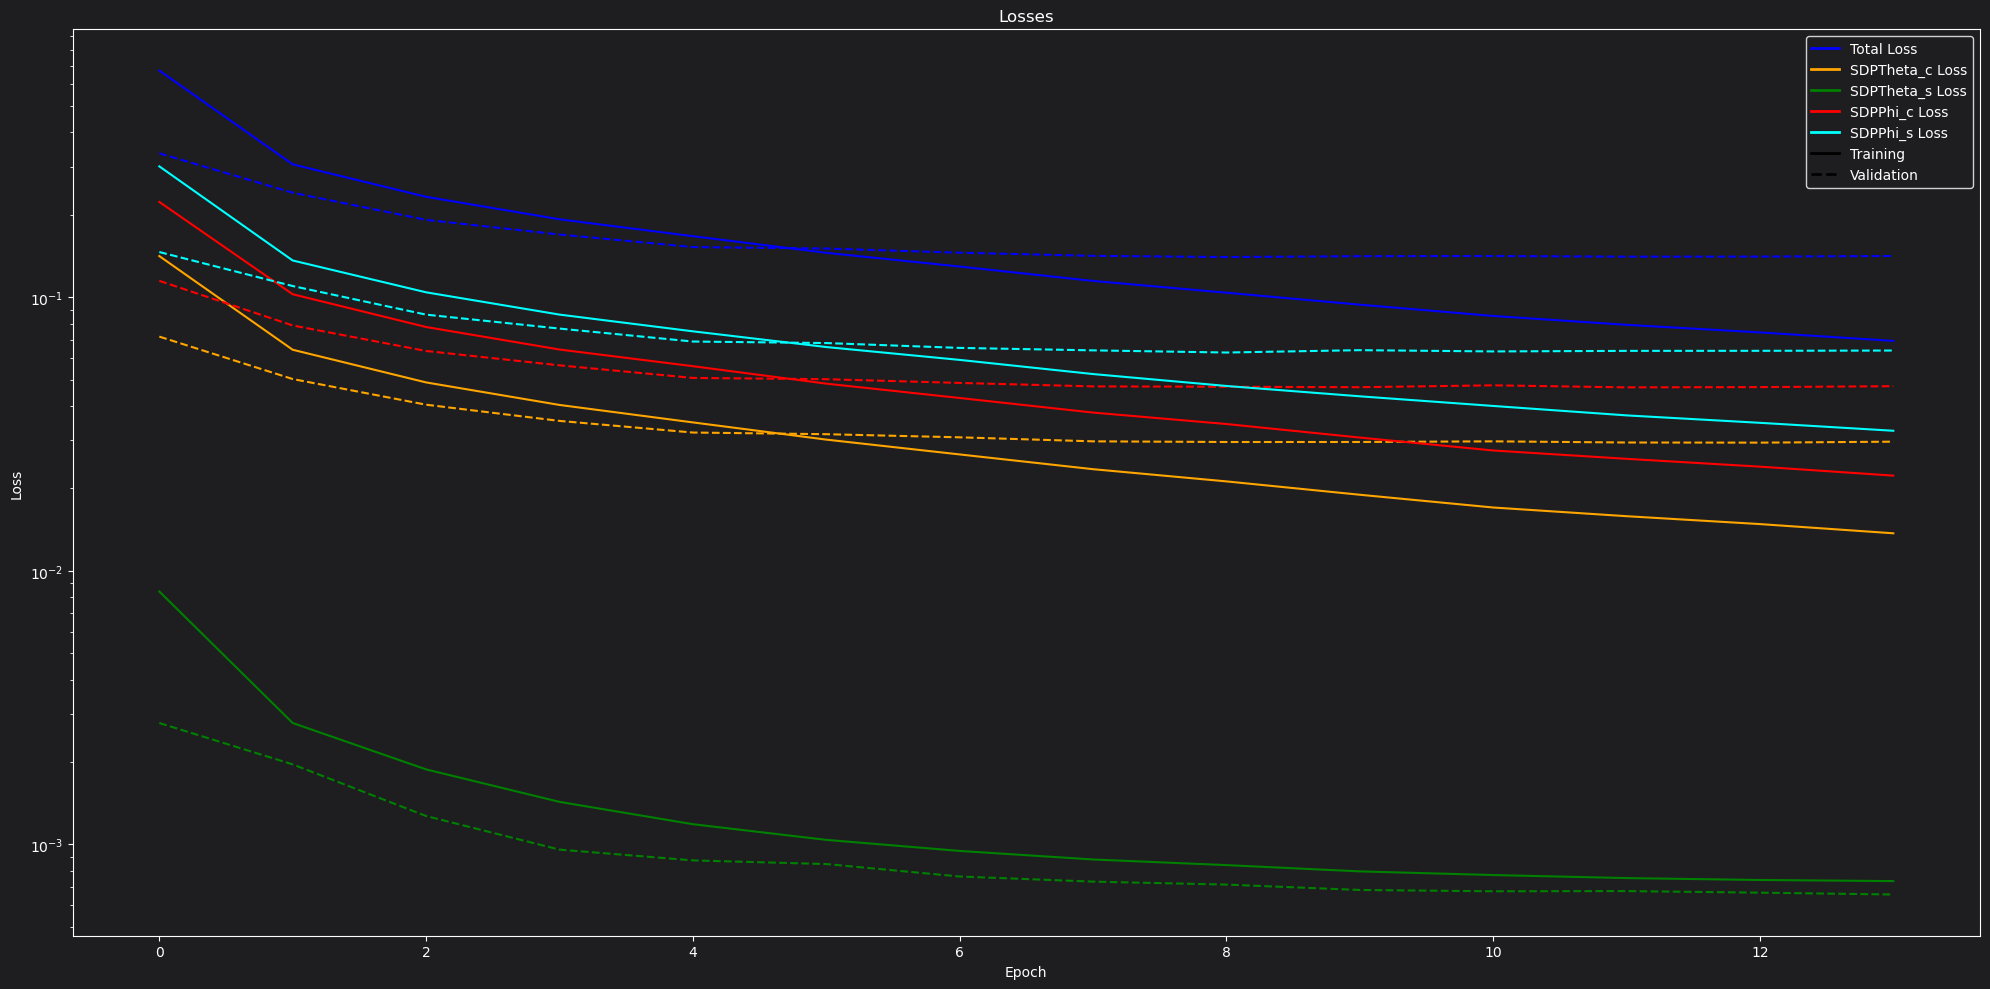

In [7]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

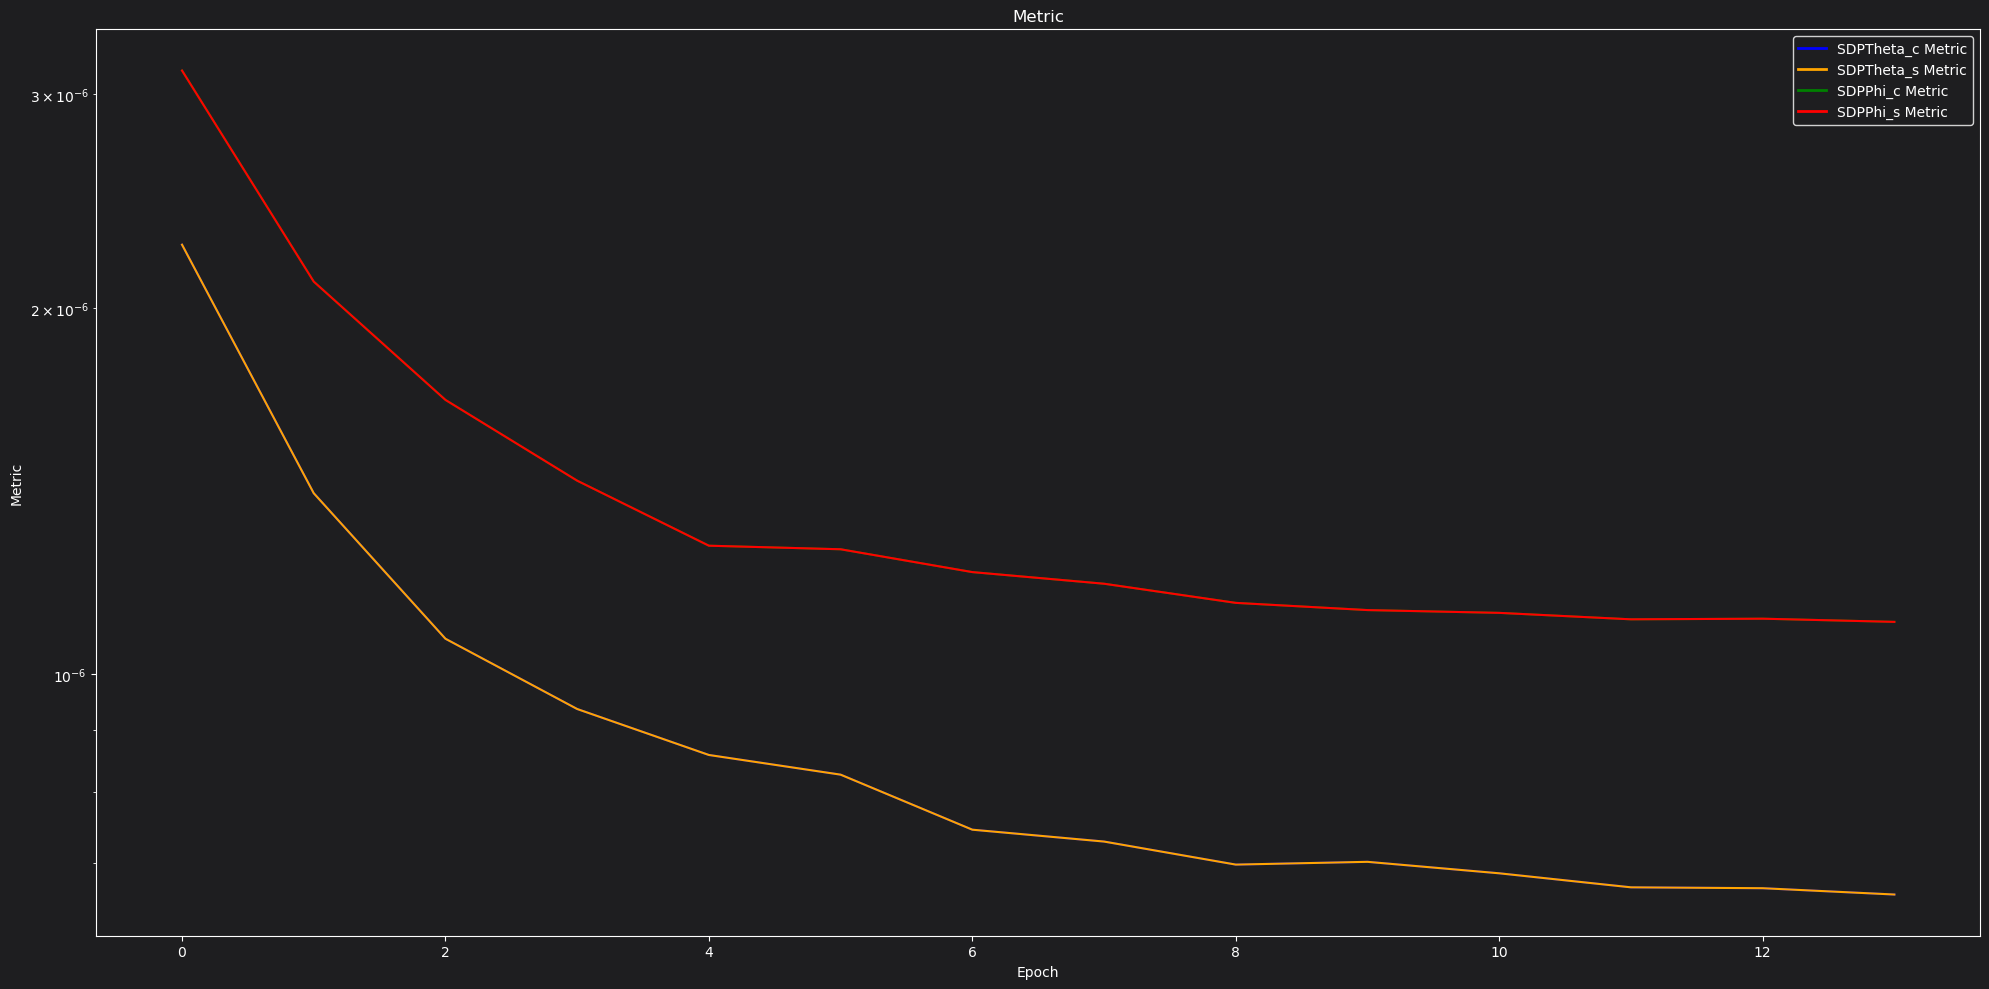

In [8]:
# Metric Plot

# Loss Plot
EpochMetrics    = Tracker.EpochMetric
Keys  = Dataset.Truth_Keys
Units = Dataset.Truth_Units
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    if   Units[i] == 'deg': plt.plot(np.array(EpochMetrics[Keys[i]]), color=colors[i], label=Keys[i] + ' - Metric')
    elif Units[i] == 'rad': plt.plot(np.array(EpochMetrics[Keys[i]])*180/np.pi, color=colors[i], label=Keys[i] + ' - Metric')
    else                  : plt.plot(np.array(EpochMetrics[Keys[i]])/1000     , color=colors[i], label=Keys[i] + ' - Metric')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Metric')



ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Metric')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric')
ax.set_yscale('log')
ax.grid()

In [9]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [10]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1
print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)




Pred Loss 0.03626647964119911
Rec  Loss 0.1393270194530487
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(37592, 2)
(37592, 2)


In [11]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi

    


for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred SDPTheta   2.1563 deg
Adjusted Percentile for Rec  SDPTheta   2.9725 deg
Percentile Ratio   Pred/Rec             0.72541

Adjusted Percentile for Pred SDPPhi     3.5694 deg
Adjusted Percentile for Rec  SDPPhi     4.8455 deg
Percentile Ratio   Pred/Rec             0.73664



#### Not particularly interesing plots

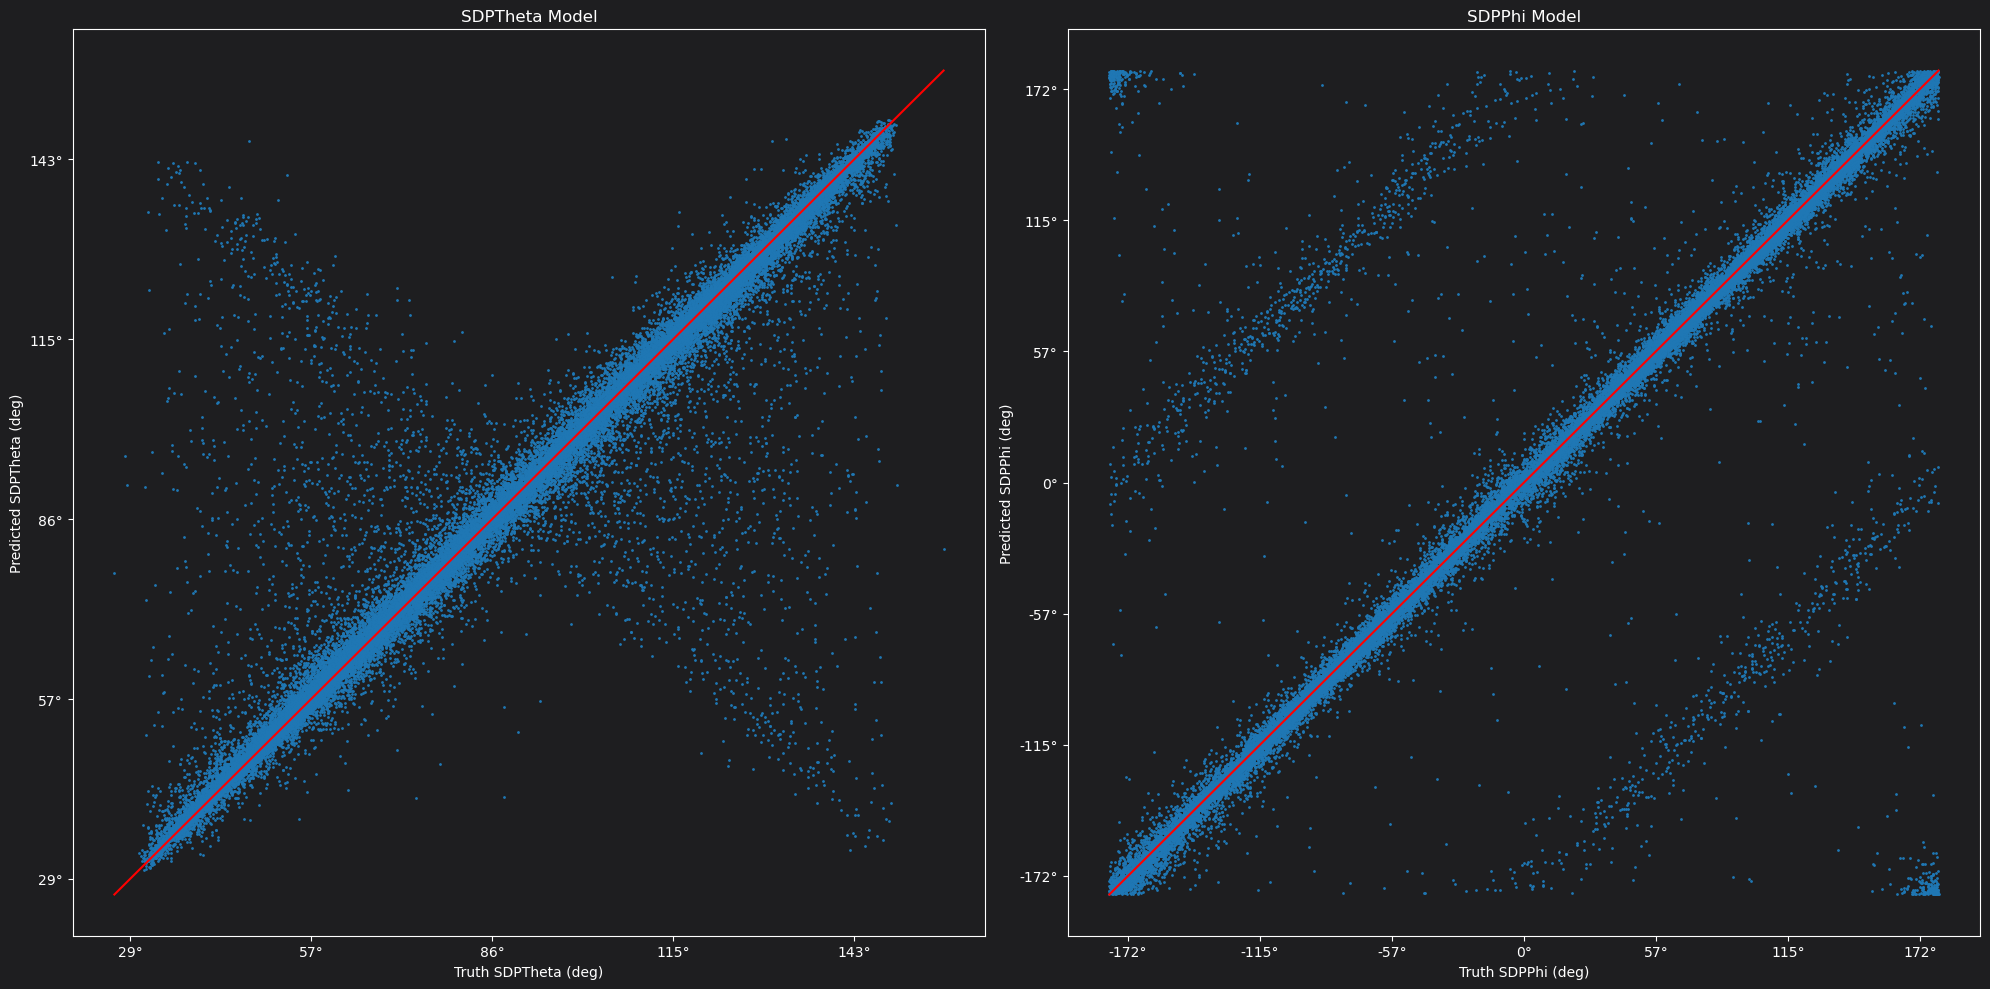

In [12]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


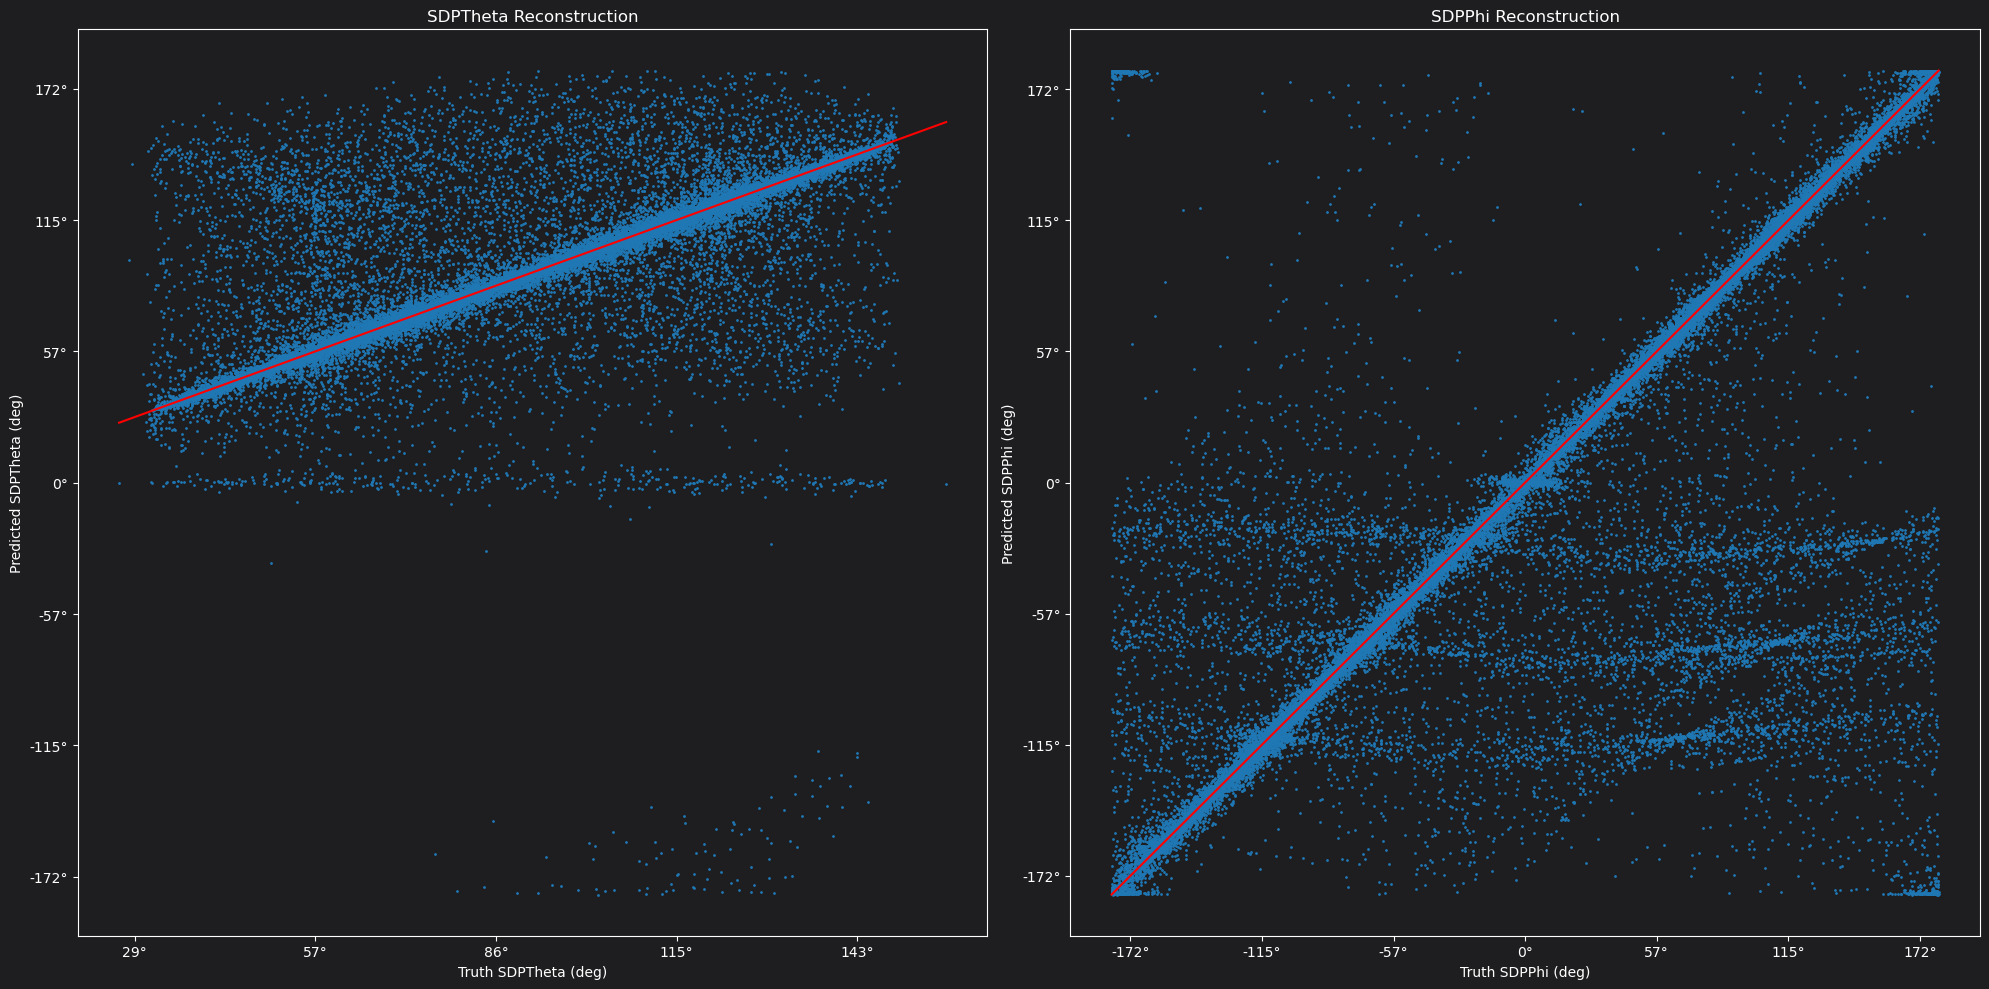

In [13]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi
    
fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


In [14]:
# def DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,Type):
#     fig, ax = plt.subplots(1, len(TruthKeys), figsize=(12.5*len(TruthKeys), 10))
#     for i in range(len(TruthKeys)):
#         X = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
#         Y = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        
        
#         # Scaling Cuts
#         if TruthKeys[i] == 'SDPTheta':
#             cut = (X > 0.1) & (np.abs(Y)<6)
#         elif TruthKeys[i] == 'SDPPhi':
#             cut = (np.abs(Y)<3) & (np.abs(X)<50)
#         elif TruthKeys[i] == 'Chi0':
#             cut = (np.abs(Y)<20)
#         elif TruthKeys[i] == 'Rp':
#             cut = (np.abs(Y)<5000)
#         elif TruthKeys[i] == 'T0':
#             cut = (np.abs(Y)<10000)
#         else:
#             cut = (np.abs(Y)>-1)


#         X = X[cut]
#         Y = Y[cut]

#         sns.scatterplot(x=X, y=Y, ax=ax[i], s=5,color='black')
#         sns.histplot(x=X, y=Y, ax=ax[i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
#         if TruthUnits[i] != 'rad': 
#             ax[i].set_ylabel(f'{Type}-Truth ({TruthUnits[i]})')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
            
#         else:                      
#             ax[i].set_ylabel(f'{Type}-Truth (degrees)')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
#         ax[i].set_title(f'{TruthKeys[i]} - {Type}')
#         ax[i].set_xlim(min(X),max(X))
#         ax[i].grid()
#         # 68th Percentile
#         Percentile68 = np.percentile(np.abs(Y),68)
#         # Add as a texbox to top right of plot
#         if TruthUnits[i]!= 'rad': ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)
#         else: ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)

#         ax[i].axhline(Percentile68, color='cyan', linestyle='--')
#         ax[i].axhline(-Percentile68, color='cyan', linestyle='--')

#     return fig
    


In [15]:
# # Deviation Plots
# TruthKeys  = Dataset.Truth_Keys
# TruthUnits = Dataset.Truth_Units

# ModelDeviation = DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,'Model')
# RecDeviation   = DeviationPlot(TruthKeys,TruthUnits,Truth,Rec,'Reconstruction')

# # Save the Figures
# # ModelDeviation.savefig(f'../Results/{Name}_Model_Deviation.png')
# # RecDeviation  .savefig(f'../Results/{Name}_Rec_Deviation.png')

#### More Interesting plots

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)


Total Points before cuts 37592
SDPTheta Total Points after cuts 37592
SDPPhi Total Points after cuts 37592


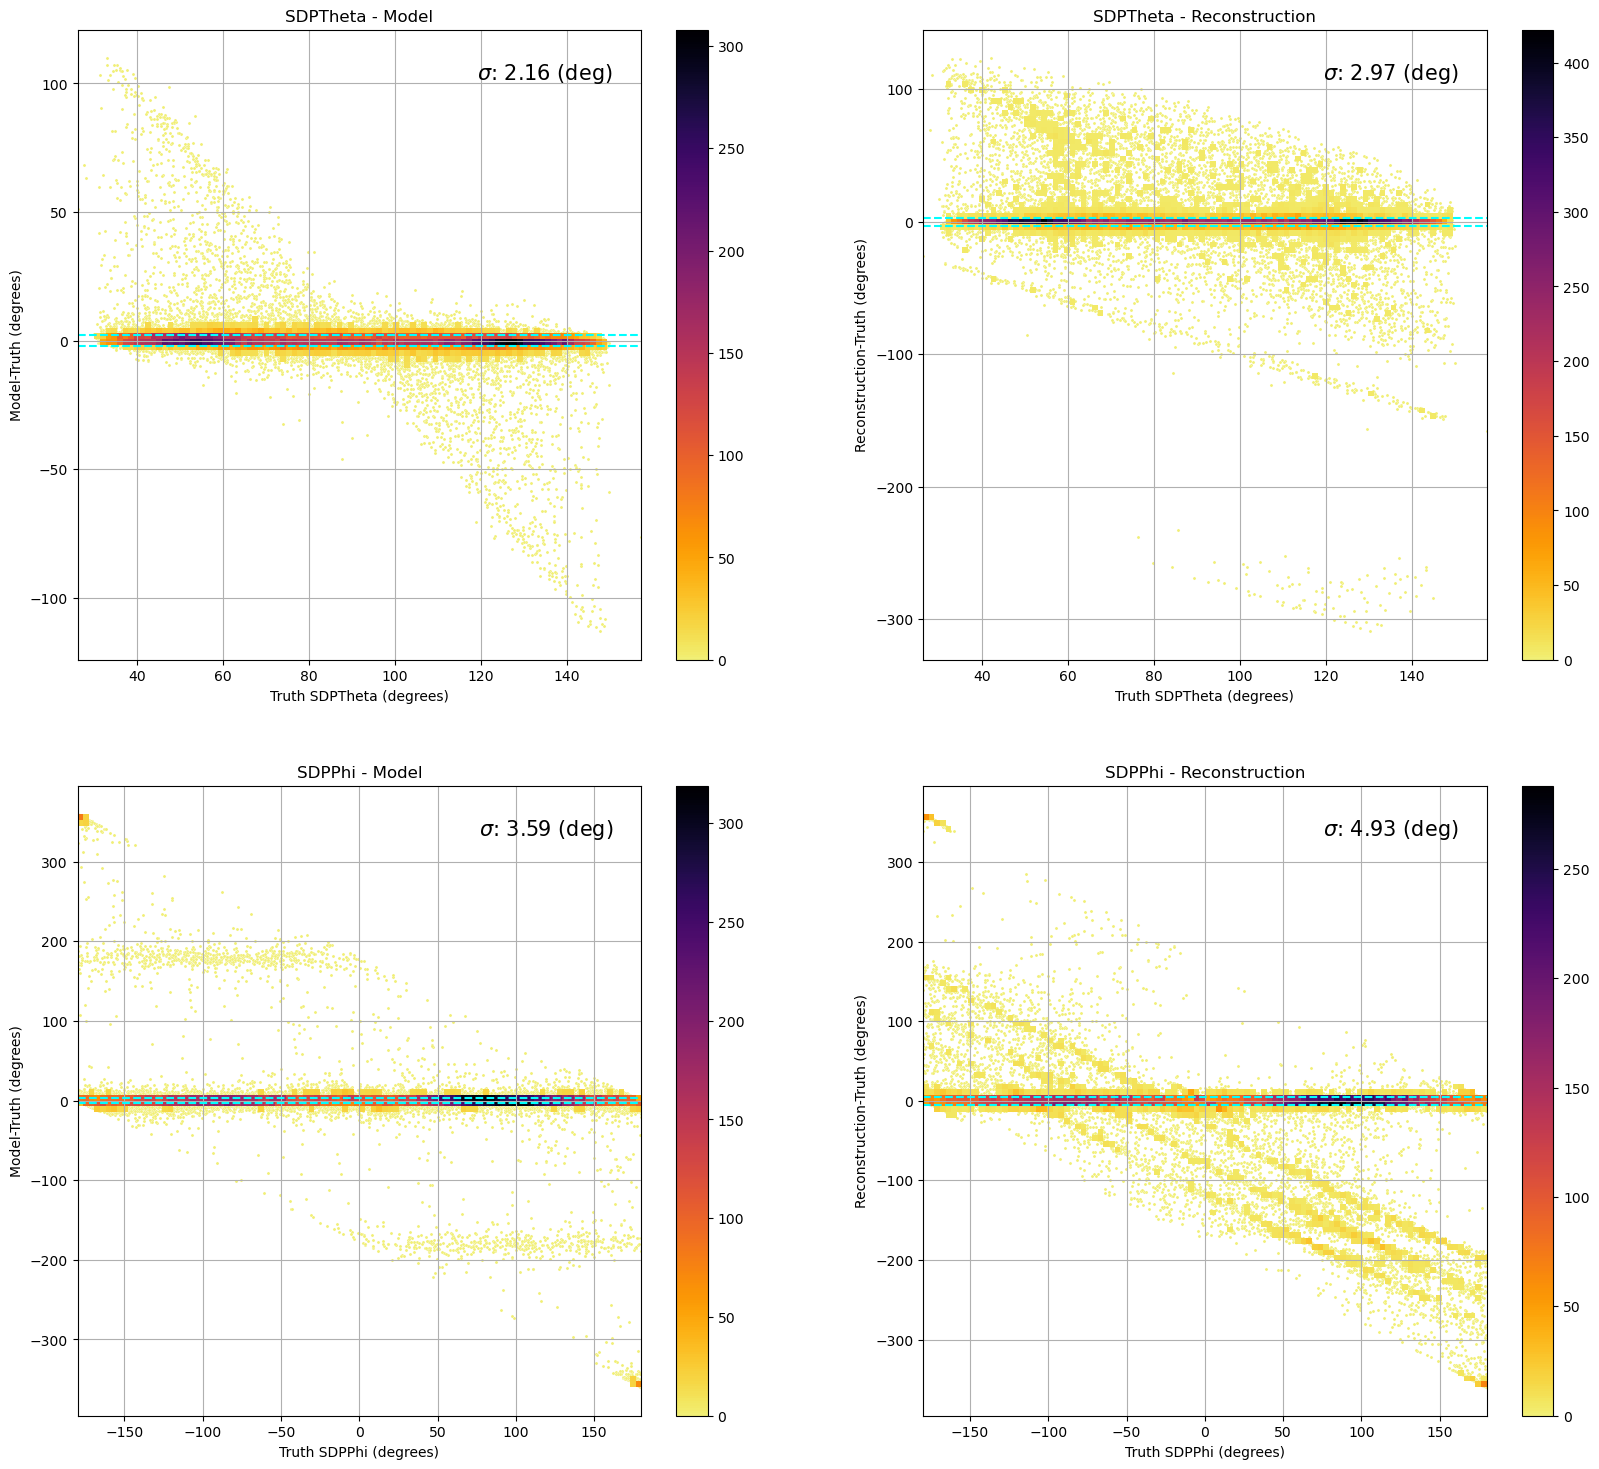

In [17]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    plt.style.use('default')
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (np.abs(Yp)>0) # (np.abs(Yp)<12)    & (np.abs(Yr)<12)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)>0) # (np.abs(Yp)<3)     & (np.abs(Yr)<3) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        # Yp_STD = np.percentile(np.abs(Yp),68)
        # cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        # X  = X [cut]
        # Yp = Yp[cut]
        # Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

Total Points before cuts 37592
SDPTheta Total Points after cuts 37592
SDPPhi Total Points after cuts 37592


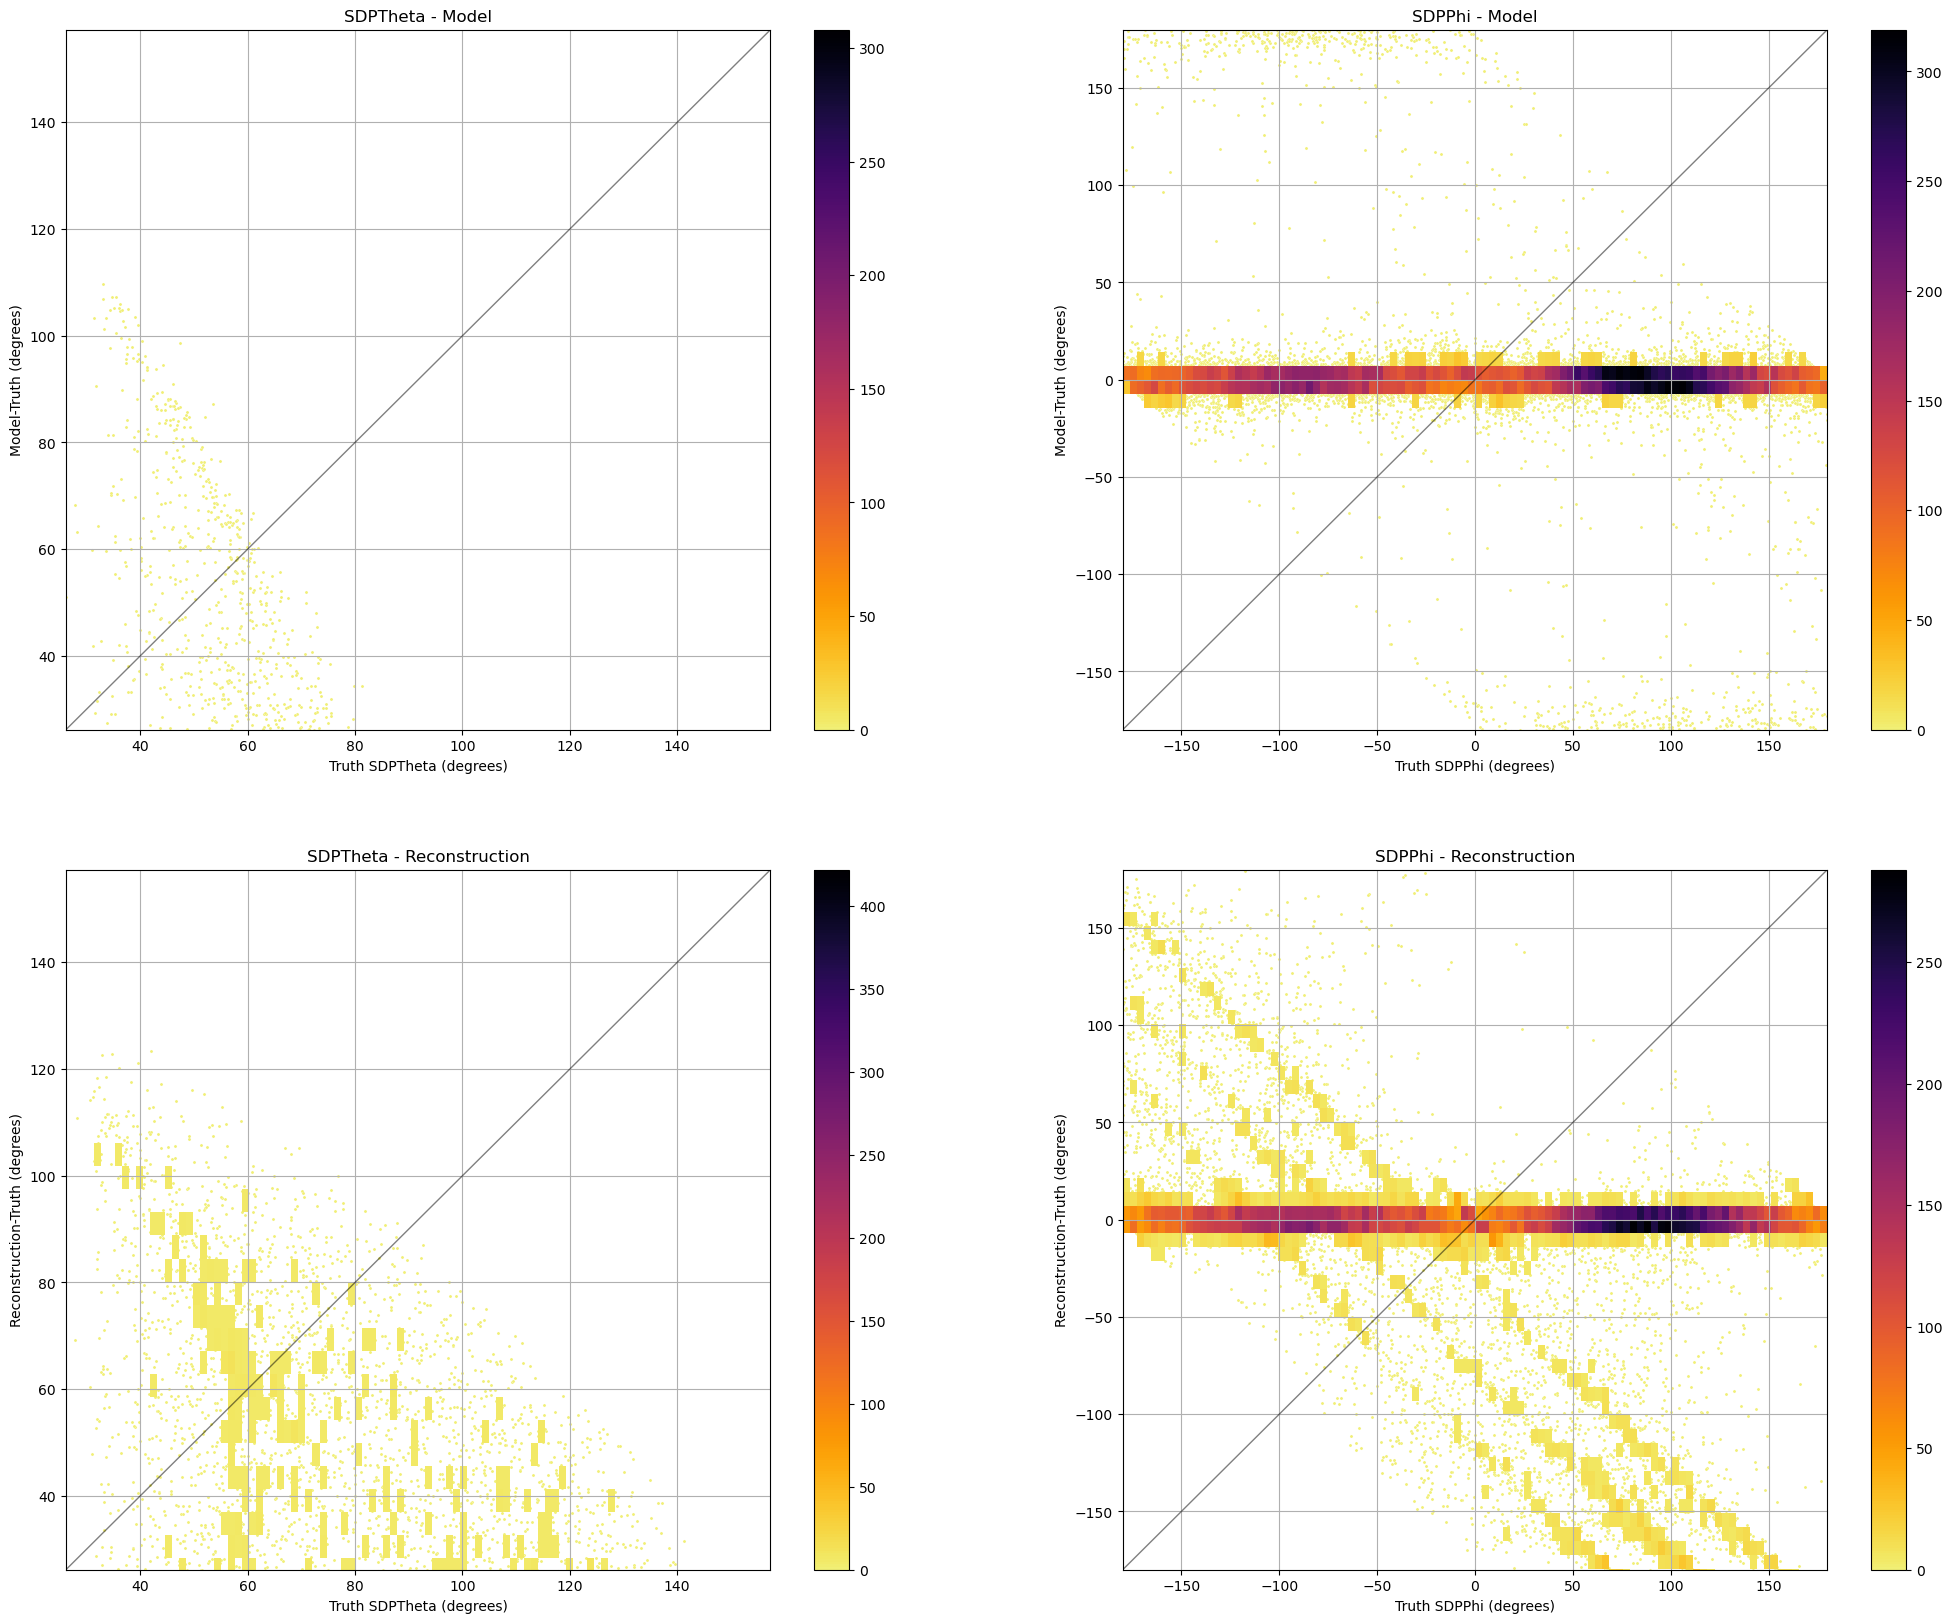

In [18]:
def CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec,FaceColor='white'):
    fig, ax = plt.subplots(2, len(TruthKeys), figsize=(12.5*len(TruthKeys), 20))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        cut = (np.abs(Yp)>-1)
        # if TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        # elif TruthKeys[i] == 'SDPPhi': cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3)    & (np.abs(X)<50)
        # elif TruthKeys[i] == 'Chi0'  : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        # elif TruthKeys[i] == 'Rp'    : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'CEDist': cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'T0'    : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        # # elif TruthKeys[i] == 'Xmax'  : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        # elif TruthKeys[i] == 'LogE'  : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        # elif TruthKeys[i] == 'z'     : cut = (X>0.4) 
        # else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)>-1)# (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[0,i], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[1,i], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[0,i].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[1,i].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[0,i].set_ylabel(f'Model-Truth (degrees)')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[1,i].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[0,i].set_title(f'{TruthKeys[i]} - Model')
        ax[1,i].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[0,i].set_xlim(min(X),max(X))
        ax[1,i].set_xlim(min(X),max(X))

        ax[0,i].set_ylim(min(X),max(X))
        ax[1,i].set_ylim(min(X),max(X))


        ax[0,i].grid()
        ax[1,i].grid()


        # Truth Line

        ax[0,i].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)
        ax[1,i].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)


        ax[0,i].set_facecolor(FaceColor)
        ax[1,i].set_facecolor(FaceColor)

        
    return fig
    
figure = CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_NonDeviation.png')

#### Other Plots

Sigma Pred:  3.9128401
Sigma Rec :  5.4966154


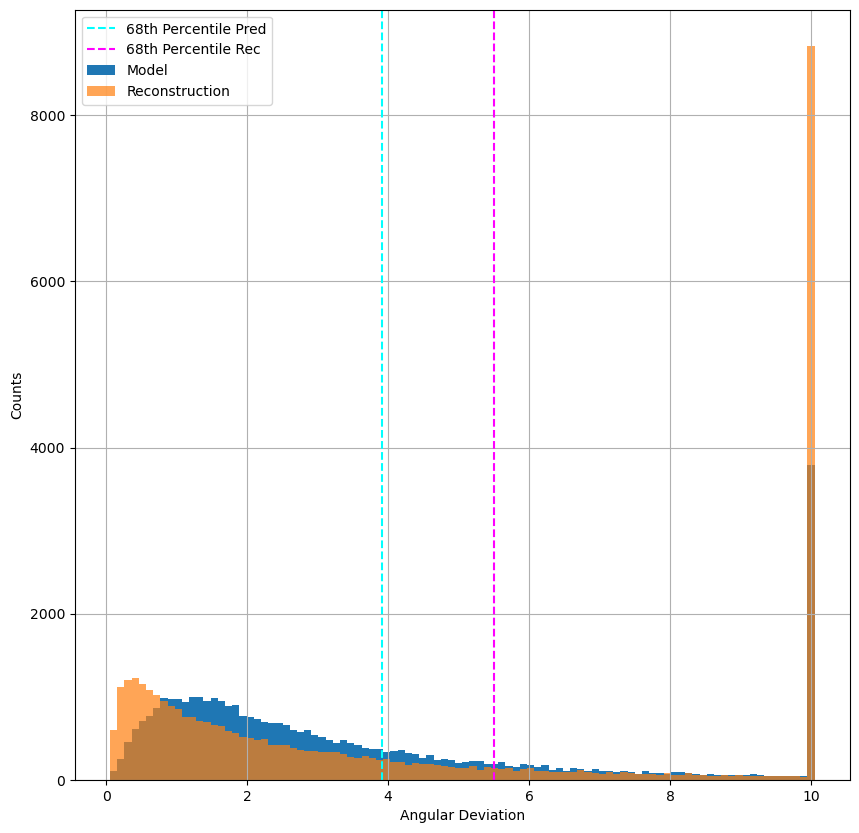

In [19]:
# Angular Deviation of SDP

try:
    SDPTheta_index =  TruthKeys.index('SDPTheta')
    SDPPhi_index   =  TruthKeys.index('SDPPhi')
except:
    pass
# Normalize the vectors to unit vectors
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=1)
    return vectors / norms[:, np.newaxis]

# Compute the angular deviation
def compute_angular_deviation(truth, pred, rec):
    truth = normalize_vectors(truth)
    pred = normalize_vectors(pred)
    rec = normalize_vectors(rec)
    

    pred_dot_product = np.einsum('ij,ij->i', truth, pred)
    rec_dot_product = np.einsum('ij,ij->i', truth, rec)
    
    pred_ang_div = np.arccos(np.clip(pred_dot_product, -1.0, 1.0))
    rec_ang_div = np.arccos(np.clip(rec_dot_product, -1.0, 1.0))

    return pred_ang_div, rec_ang_div

def angles_to_vector(Thetas,Phis):
    X = np.sin(Thetas)*np.cos(Phis)
    Y = np.sin(Thetas)*np.sin(Phis)
    Z = np.cos(Thetas)
    return np.array([X,Y,Z]).T




# Truth_Vecs = angles_to_vector(np.deg2rad(Truth[:,SDPTheta_index]),np.deg2rad(Truth[:,SDPPhi_index]))
# Pred_Vecs  = angles_to_vector(np.deg2rad(Pred [:,SDPTheta_index]),np.deg2rad(Pred [:,SDPPhi_index]))
# Rec_Vecs   = angles_to_vector(np.deg2rad(Rec  [:,SDPTheta_index]),np.deg2rad(Rec  [:,SDPPhi_index]))

Truth_Vecs = angles_to_vector(Truth[:,SDPTheta_index], Truth[:,SDPPhi_index])
Pred_Vecs  = angles_to_vector(Pred [:,SDPTheta_index], Pred [:,SDPPhi_index])
Rec_Vecs   = angles_to_vector(Rec  [:,SDPTheta_index], Rec  [:,SDPPhi_index])



# Example usage
angular_deviation_pred, angular_deviation_rec = compute_angular_deviation(Truth_Vecs, Pred_Vecs, Rec_Vecs)
# Convert to deg
angular_deviation_pred = np.rad2deg(angular_deviation_pred)
angular_deviation_rec  = np.rad2deg(angular_deviation_rec)

nbins =100
Range = (0,10)

bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

plt.figure(figsize=(10, 10)) 

counts,bin_edges = np.histogram(angular_deviation_pred, bins=bins)
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model')

counts,bin_edges = np.histogram(angular_deviation_rec, bins=bins)
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction', alpha=0.7)

plt.axvline(np.percentile(angular_deviation_pred, 68), color='cyan', linestyle='--', label='68th Percentile Pred')
plt.axvline(np.percentile(angular_deviation_rec, 68), color='magenta', linestyle='--', label='68th Percentile Rec')
print('Sigma Pred: ',np.percentile(angular_deviation_pred, 68))
print('Sigma Rec : ',np.percentile(angular_deviation_rec, 68))

plt.xlabel('Angular Deviation')
plt.ylabel('Counts')
plt.legend()
plt.grid()
# plt.yscale('log')
plt.show()


#### Figure out what doesn't work

In [20]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Aux   = []

Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        Aux   .append(BatchAux)
        EvI+=1

print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)
Aux   = torch.cat(Aux  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)


if len(Aux.shape) == 3:
    Aux = Aux.squeeze()  # Add a dimension if Aux is 1D

Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()
Aux   = Aux  .numpy()

print(Truth.shape)
print(Pred.shape)
print(Rec.shape)
print(Aux.shape)

AuxKeys = ['Event_Class','Primary','Gen_LogE','Gen_CosZenith','Gen_Xmax','Gen_Chi0','Gen_Rp']
print('Auxiliary Keys:', AuxKeys)


Pred Loss 0.03626647964119911
Rec  Loss 0.1393270194530487
(37592, 2)
(37592, 2)
(37592, 2)
(37592, 7)
Auxiliary Keys: ['Event_Class', 'Primary', 'Gen_LogE', 'Gen_CosZenith', 'Gen_Xmax', 'Gen_Chi0', 'Gen_Rp']


In [21]:
# Figure out where the model is bad but standard method is good. 

# Compute the Errors
# Example of angular deviation error: np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
SDP_Theta_Error_model = np.abs(np.arctan2(np.sin(Truth[:,0]  -Pred[:,0]),np.cos(Truth[:,0]  -Pred[:,0])))
SDP_Phi_Error_model   = np.abs(np.arctan2(np.sin(Truth[:,1]  -Pred[:,1]),np.cos(Truth[:,1]  -Pred[:,1])))
SDP_Theta_Error_rec   = np.abs(np.arctan2(np.sin(Truth[:,0]  -Rec[:,0] ),np.cos(Truth[:,0]  -Rec[:,0] )))
SDP_Phi_Error_rec     = np.abs(np.arctan2(np.sin(Truth[:,1]  -Rec[:,1] ),np.cos(Truth[:,1]  -Rec[:,1] )))

# Error Thresholds 
Good_Percentile = 10
Bad_Percentile  = 90

Model_Bad_Theta_Threshold = np.percentile(SDP_Theta_Error_model, Bad_Percentile)
Model_Bad_Phi_Threshold   = np.percentile(SDP_Phi_Error_model  , Bad_Percentile)

Rec_Good_Theta_Threshold = np.percentile(SDP_Theta_Error_rec  , Good_Percentile)
Rec_Good_Phi_Threshold   = np.percentile(SDP_Phi_Error_rec    , Good_Percentile)

print(f'Model Bad Theta Threshold: {Model_Bad_Theta_Threshold:.5}')
print(f'Model Bad Phi Threshold  : {Model_Bad_Phi_Threshold:.5}')
print(f'Rec Good Theta Threshold : {Rec_Good_Theta_Threshold:.5}')
print(f'Rec Good Phi Threshold   : {Rec_Good_Phi_Threshold:.5}')
print()
# Compute the Mask for the events where the model is bad but the reconstruction is good
Mask = (SDP_Theta_Error_model > Model_Bad_Theta_Threshold) & (SDP_Phi_Error_model > Model_Bad_Phi_Threshold) & \
       (SDP_Theta_Error_rec < Rec_Good_Theta_Threshold) & (SDP_Phi_Error_rec < Rec_Good_Phi_Threshold)

print(f'Selecting {Mask.sum()} events out of {len(Truth)} where the model is bad but the reconstruction is good.')

# Selected indices
Selected_Indices = np.where(Mask)[0]
print(f'Selected Indices: {Selected_Indices}')


Model Bad Theta Threshold: 0.10543
Model Bad Phi Threshold  : 0.1569
Rec Good Theta Threshold : 0.002386
Rec Good Phi Threshold   : 0.0048445

Selecting 28 events out of 37592 where the model is bad but the reconstruction is good.
Selected Indices: [  716  2072  3090  3427  9497 10862 11361 11677 13164 13852 15878 19430
 19734 19798 19929 20844 23428 23761 24357 24526 26825 26925 27258 29471
 32039 32561 32718 36205]


In [22]:
print(f'Model Bad Theta Threshold: {float(Model_Bad_Theta_Threshold):.5f}')
print(f'Model Bad Phi Threshold  : {float(Model_Bad_Phi_Threshold):.5f}')
print(f'Rec Good Theta Threshold : {float(Rec_Good_Theta_Threshold):.5f}')
print(f'Rec Good Phi Threshold   : {float(Rec_Good_Phi_Threshold):.5f}')

Model Bad Theta Threshold: 0.10543
Model Bad Phi Threshold  : 0.15690
Rec Good Theta Threshold : 0.00239
Rec Good Phi Threshold   : 0.00484


In [23]:
# Does bad theta prediction inmply bad phi prediction?
# Compute the correlation between the errors
Correlation = np.corrcoef(SDP_Theta_Error_model, SDP_Phi_Error_model)[0, 1]
print(f'Model correlation between SDP Theta and Phi errors: {Correlation:.2f}')
# DO same for reconstruction
Rec_Correlation = np.corrcoef(SDP_Theta_Error_rec, SDP_Phi_Error_rec)[0, 1]
print(f'Reconstruction correlation between SDP Theta and Phi errors: {Rec_Correlation:.2f}')

Model correlation between SDP Theta and Phi errors: 0.81
Reconstruction correlation between SDP Theta and Phi errors: 0.75


Text(0, 0.5, 'Reconstructed SDPPhi (rad)')

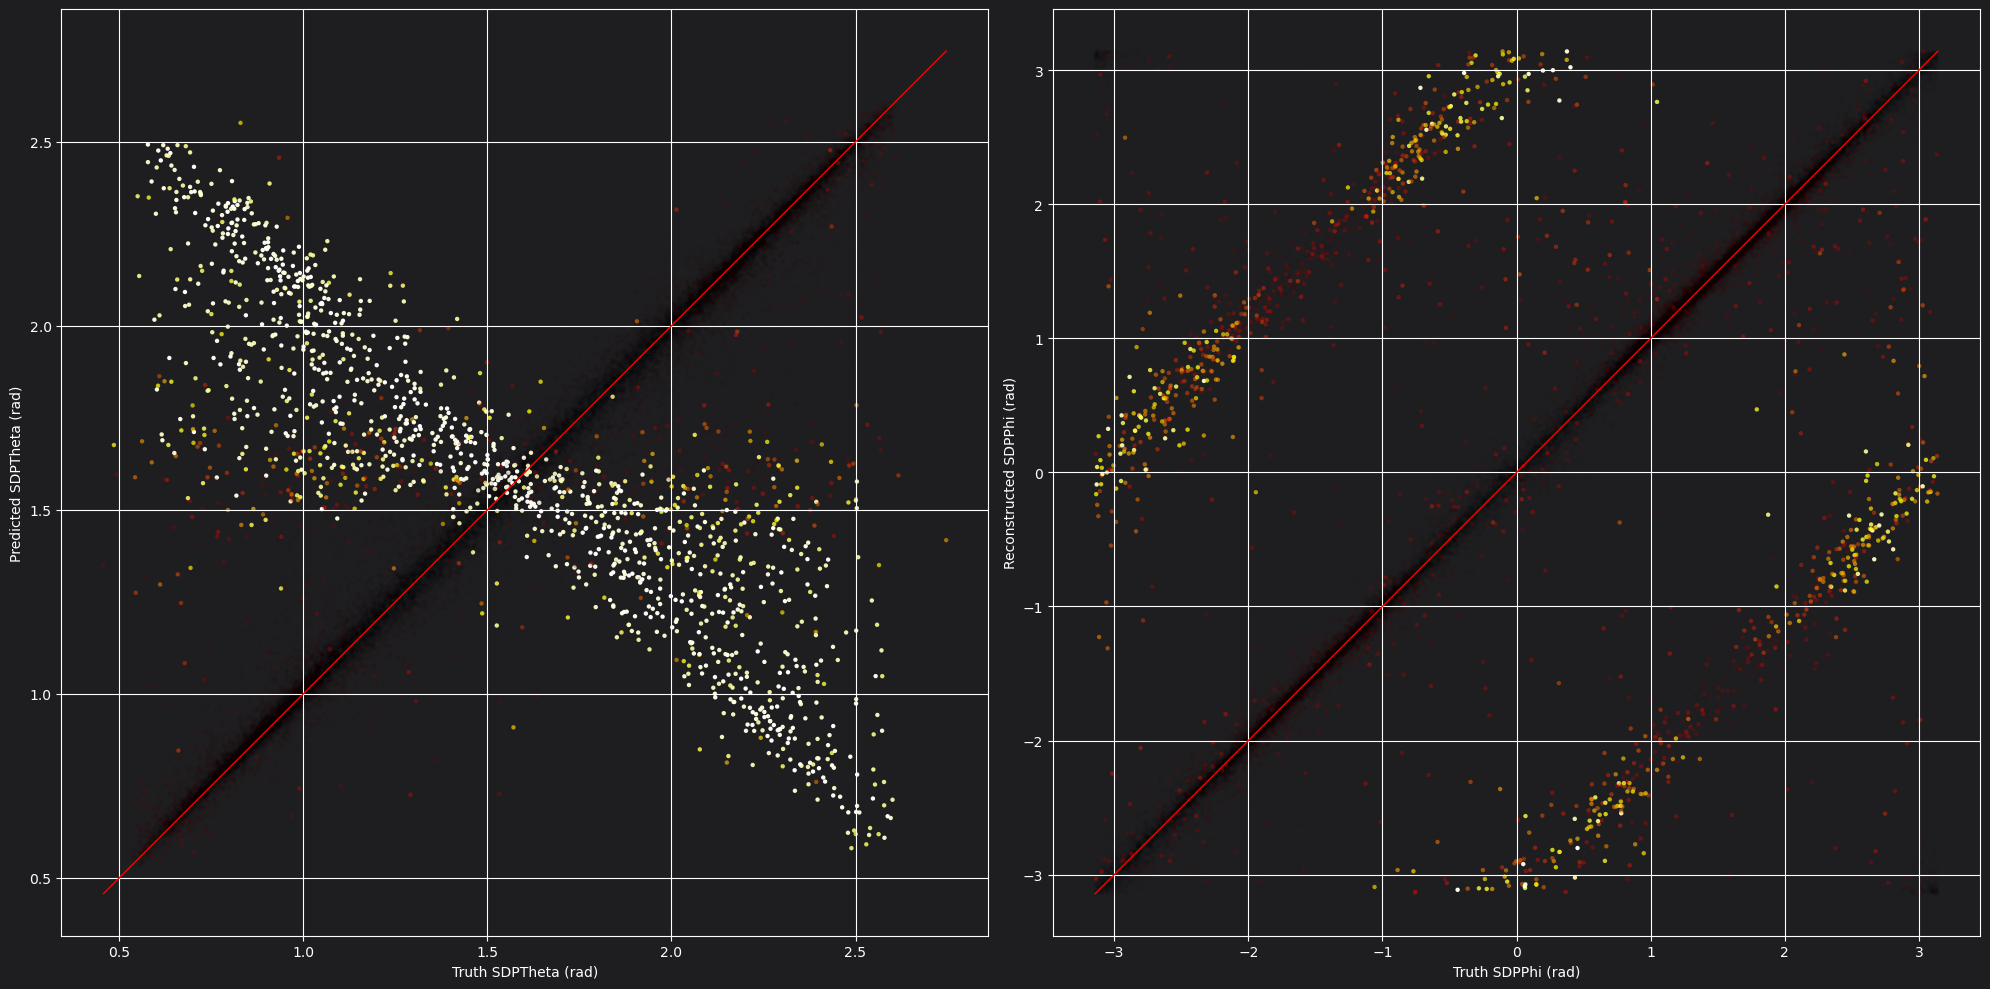

In [24]:
# crossmapping the error in Theta into color of the scatter plot for Pred vs Truth in phi, and vice versa
# reload style as i edit it
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
X = Truth[:,0]
Y = Pred [:,0]
Z = SDP_Phi_Error_model


axs[0].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[0].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[0].set_xlabel('Truth SDPTheta (rad)')
axs[0].set_ylabel('Predicted SDPTheta (rad)')   

X = Truth[:,1]
Y = Pred [:,1]
Z = SDP_Theta_Error_model

axs[1].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[1].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[1].set_xlabel('Truth SDPPhi (rad)')
axs[1].set_ylabel('Reconstructed SDPPhi (rad)')


Text(0.5, 0.98, 'Cross-mapping Errors in Theta and Phi - Reconstruction')

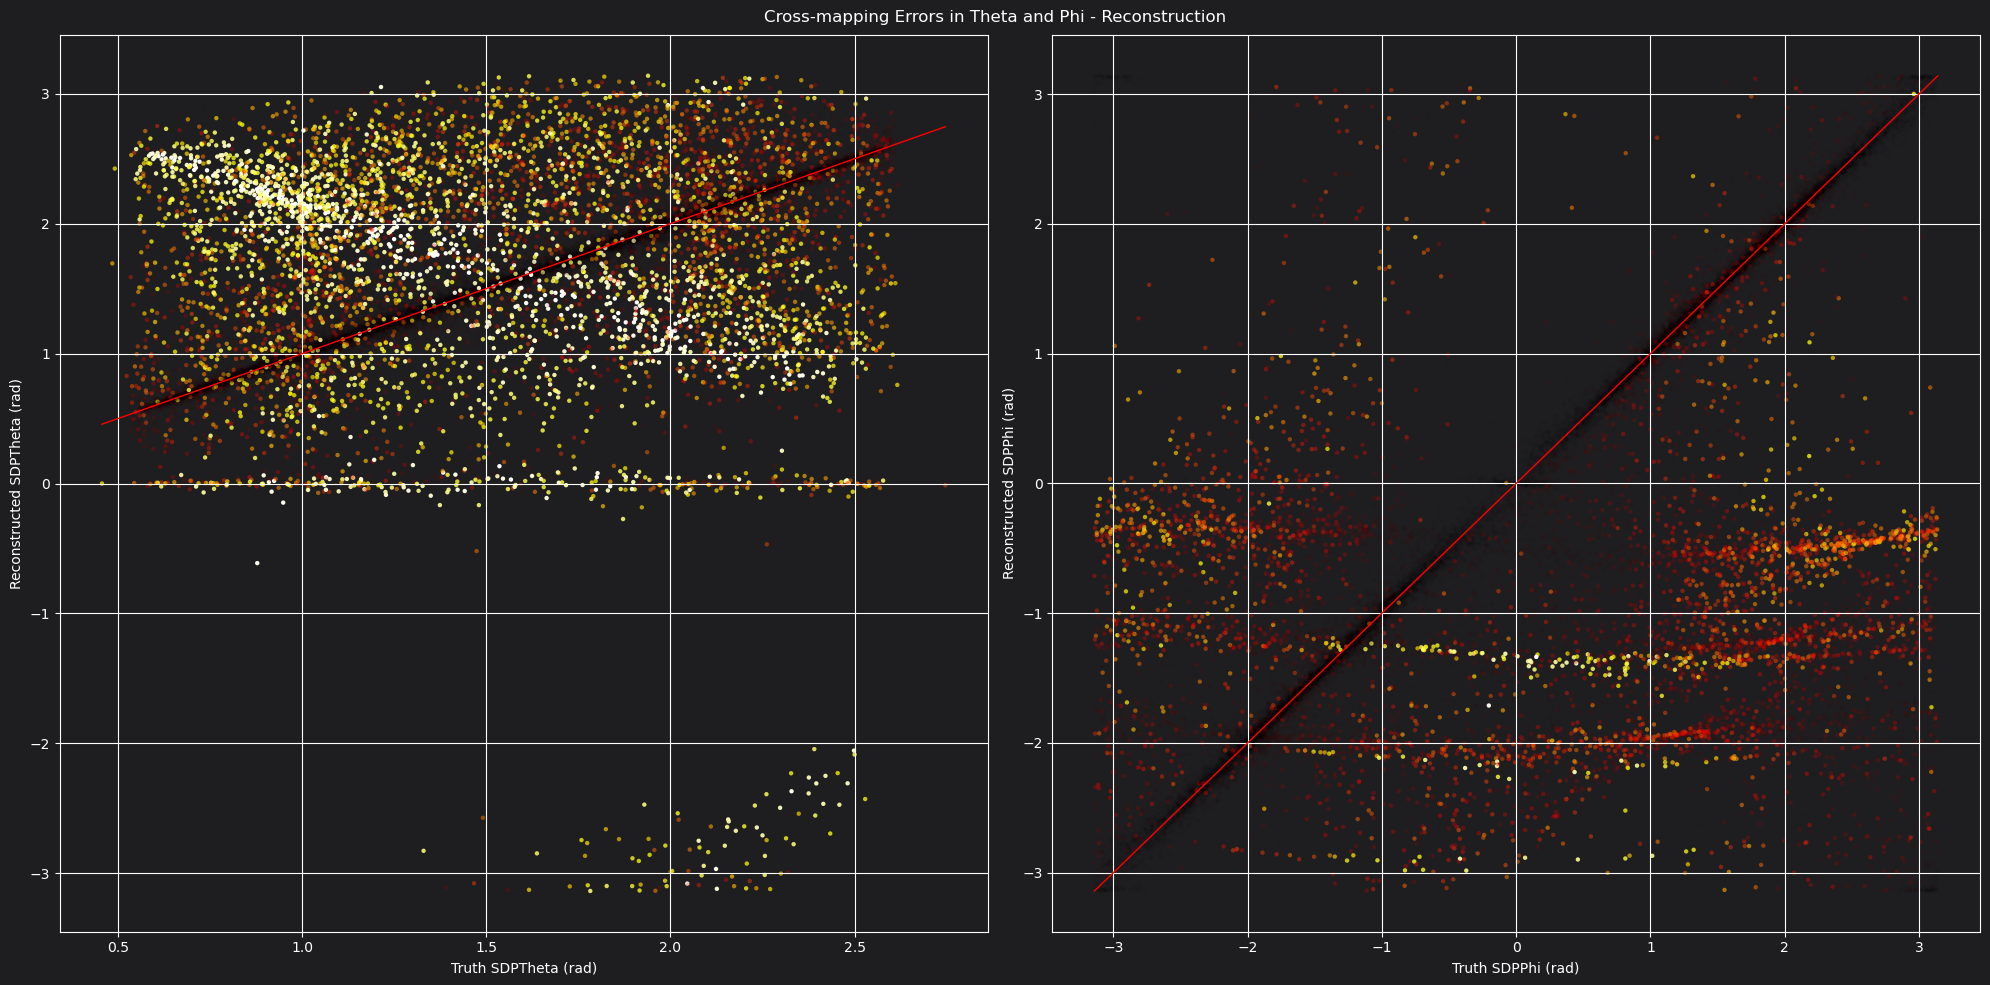

In [25]:
# crossmapping the error in Theta into color of the scatter plot for Rec vs Truth in phi, and vice versa
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Truth vs Rec for SDPTheta, colored by SDP_Phi_Error_rec
X = Truth[:, 0]
Y = Rec  [:, 0]
Z = SDP_Phi_Error_rec
axs[0].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[0].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[0].set_xlabel('Truth SDPTheta (rad)')
axs[0].set_ylabel('Reconstructed SDPTheta (rad)')

# Plot 2: Truth vs Rec for SDPPhi, colored by SDP_Theta_Error_rec
X = Truth[:, 1]
Y = Rec[:  , 1]
Z = SDP_Theta_Error_rec
axs[1].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[1].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[1].set_xlabel('Truth SDPPhi (rad)')
axs[1].set_ylabel('Reconstructed SDPPhi (rad)')

fig.suptitle('Cross-mapping Errors in Theta and Phi - Reconstruction')

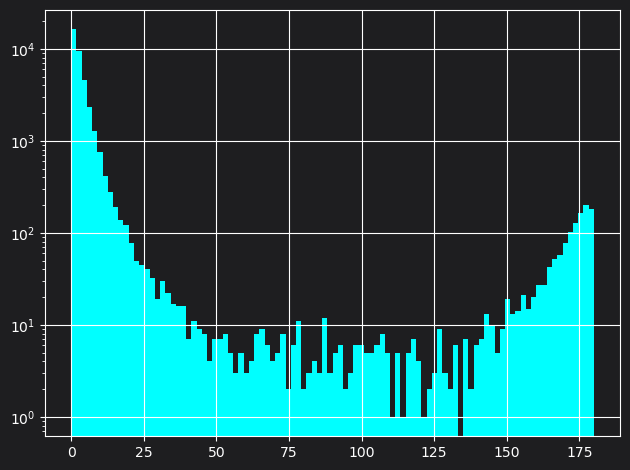

In [26]:
plt.figure()
plt.hist(SDP_Phi_Error_model*180/np.pi, bins=100,color='cyan')
plt.yscale('log')
plt.show()


In [27]:
# Redo the simple plots from above, whilst removing the angular deviation of greater than 1625 degrees
# This is the case where the normal of the SDP is inverted. 

Mask = (SDP_Phi_Error_model < 125 * np.pi / 180)

Truth = Truth[Mask]
Pred  = Pred[Mask]
Rec   = Rec[Mask]

SDP_Phi_Error_model = SDP_Phi_Error_model[Mask]
SDP_Theta_Error_model = SDP_Theta_Error_model[Mask]
SDP_Phi_Error_rec = SDP_Phi_Error_rec[Mask]
SDP_Theta_Error_rec = SDP_Theta_Error_rec[Mask]


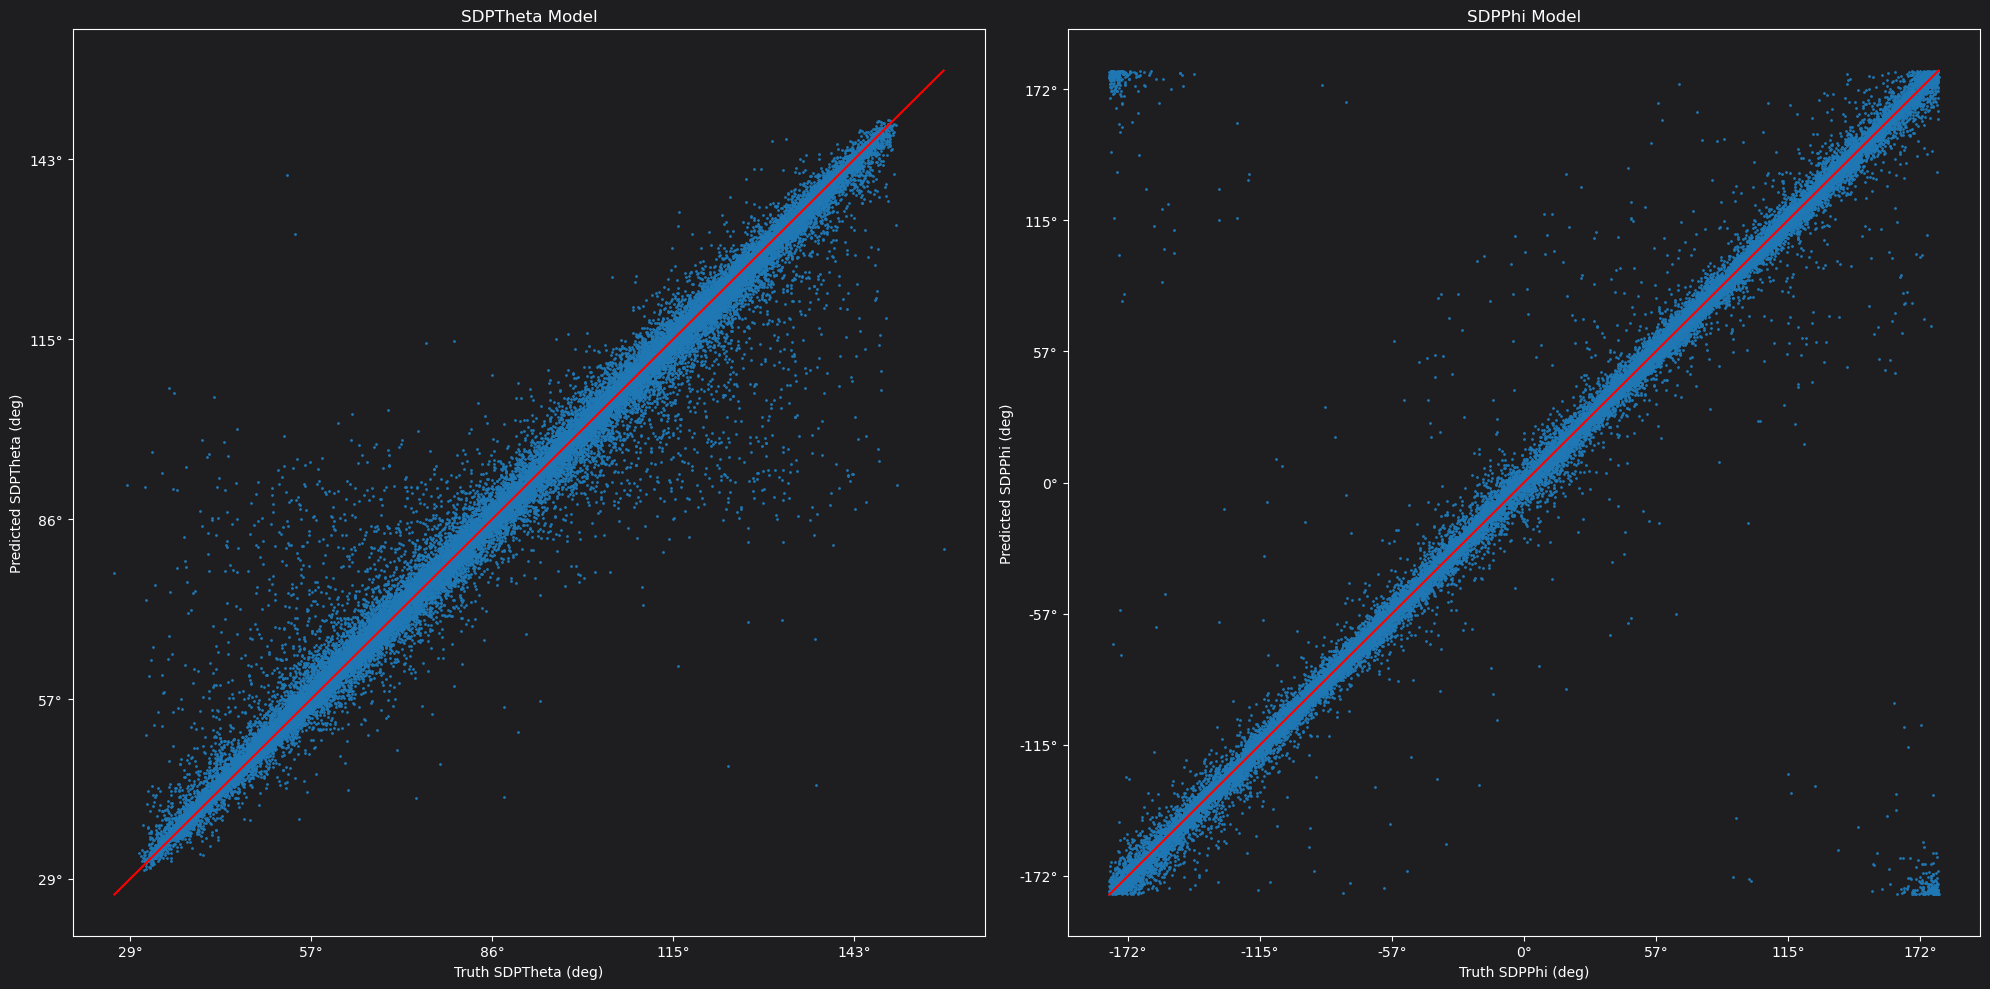

In [28]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


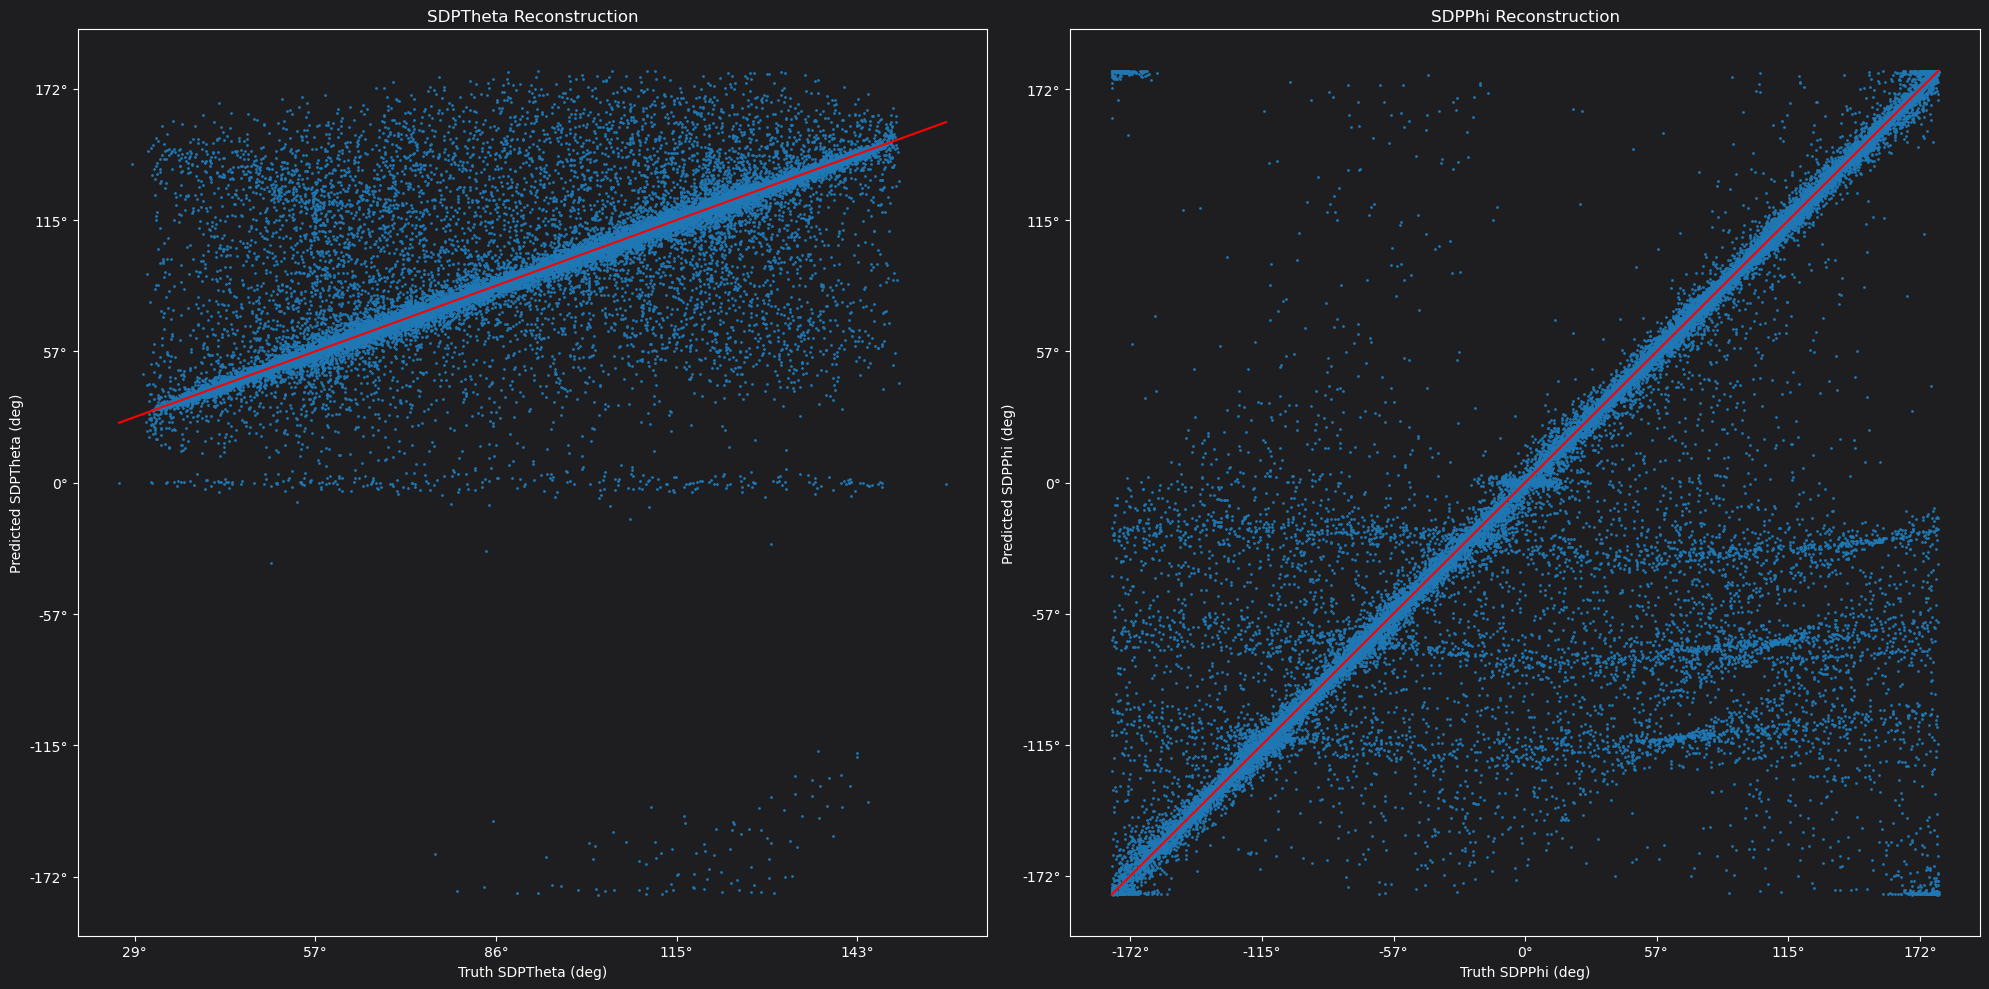

In [29]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi
    
fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


Text(0, 0.5, 'Reconstructed SDPPhi (rad)')

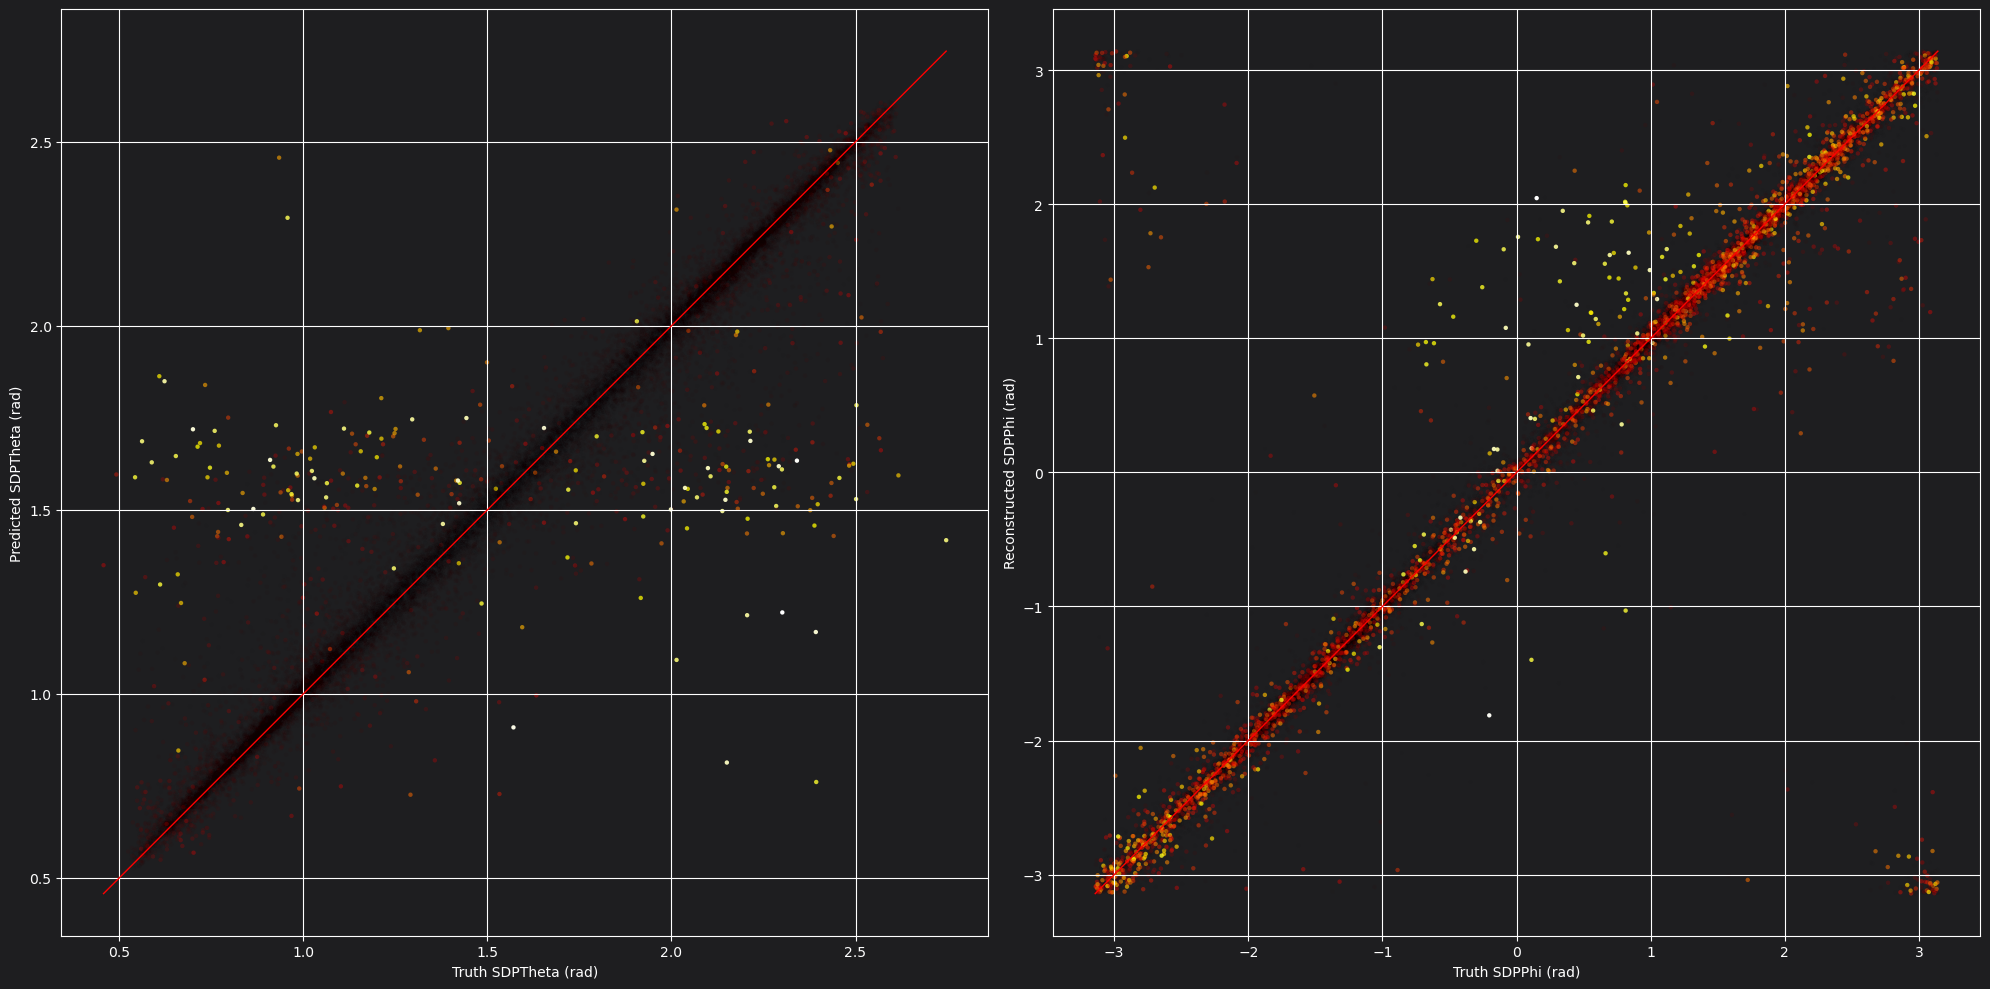

In [30]:
# crossmapping the error in Theta into color of the scatter plot for Pred vs Truth in phi, and vice versa
# reload style as i edit it
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
X = Truth[:,0]
Y = Pred [:,0]
Z = SDP_Phi_Error_model


axs[0].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[0].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[0].set_xlabel('Truth SDPTheta (rad)')
axs[0].set_ylabel('Predicted SDPTheta (rad)')   

X = Truth[:,1]
Y = Pred [:,1]
Z = SDP_Theta_Error_rec

axs[1].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[1].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[1].set_xlabel('Truth SDPPhi (rad)')
axs[1].set_ylabel('Reconstructed SDPPhi (rad)')


Text(0, 0.5, 'Reconstructed SDPPhi (rad)')

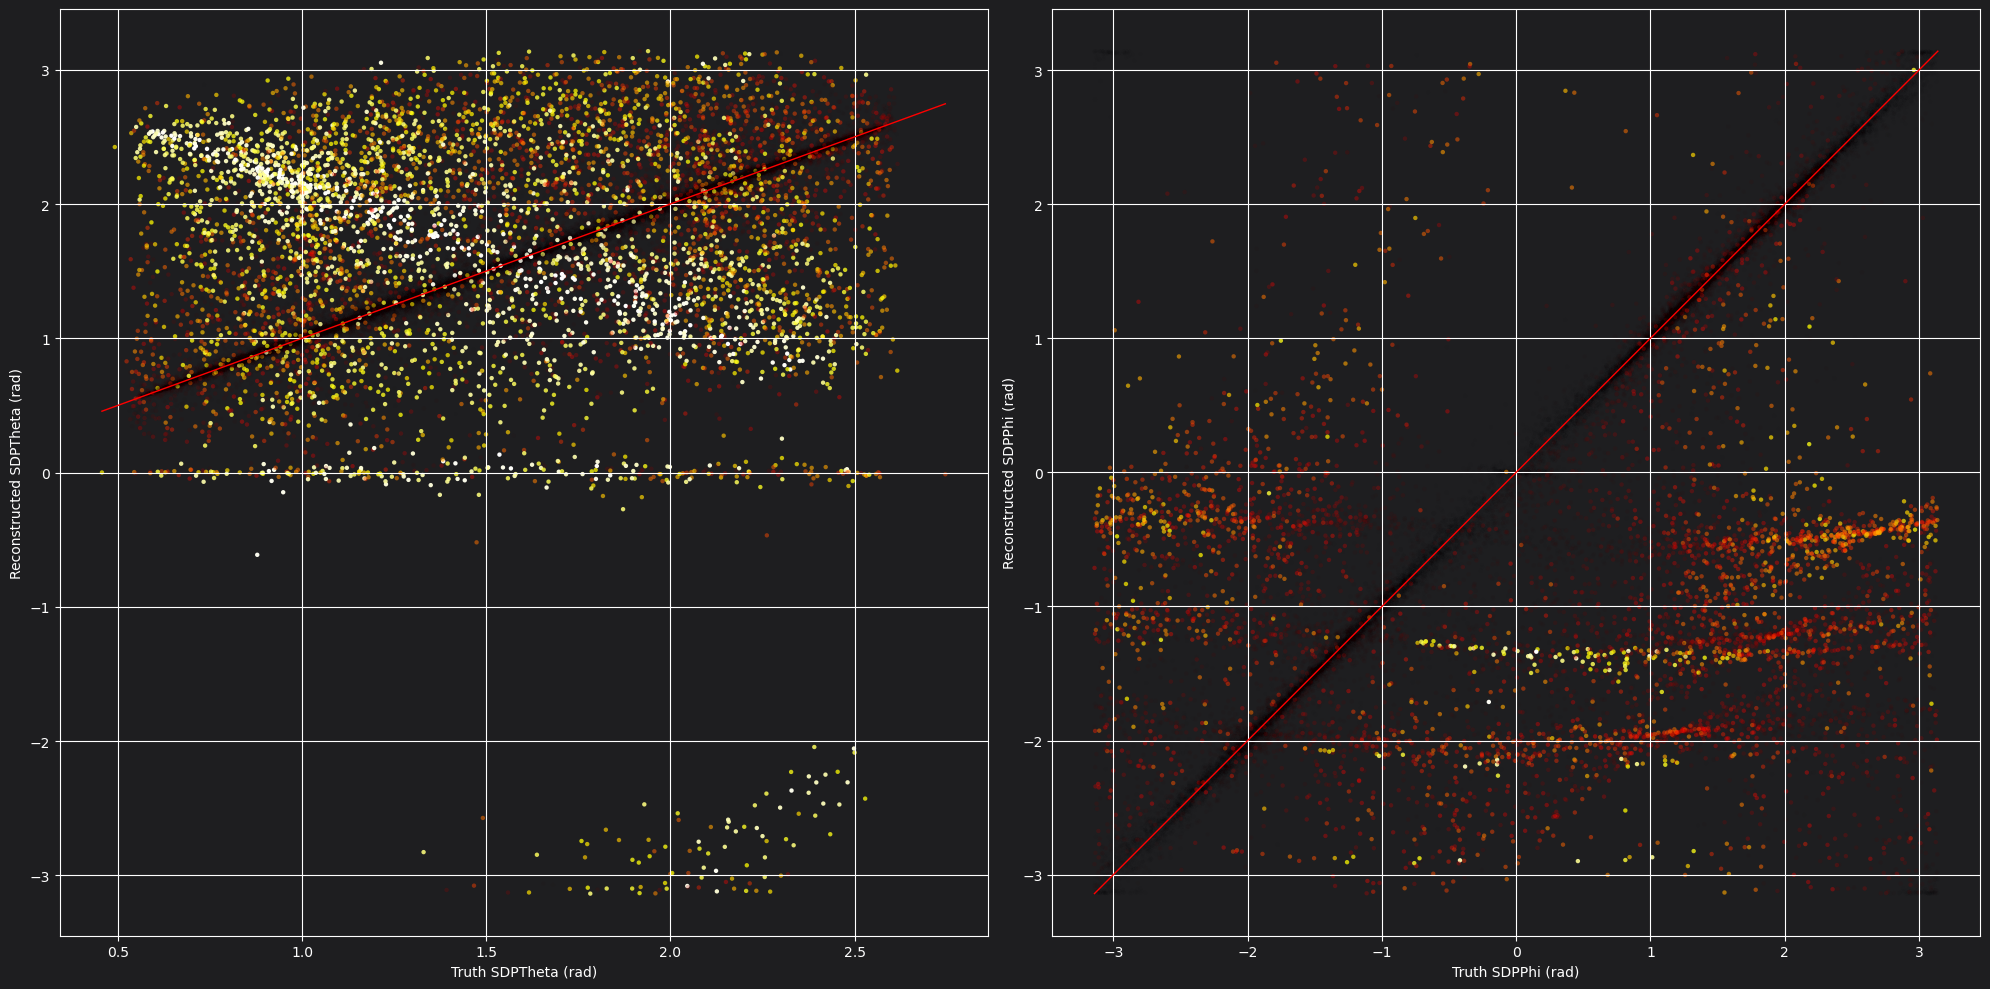

In [31]:
# crossmapping the error in Theta into color of the scatter plot for Rec vs Truth in phi, and vice versa
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Truth vs Rec for SDPTheta, colored by SDP_Phi_Error_rec
X = Truth[:, 0]
Y = Rec  [:, 0]
Z = SDP_Phi_Error_rec
axs[0].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[0].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[0].set_xlabel('Truth SDPTheta (rad)')
axs[0].set_ylabel('Reconstructed SDPTheta (rad)')

# Plot 2: Truth vs Rec for SDPPhi, colored by SDP_Theta_Error_rec
X = Truth[:, 1]
Y = Rec[:  , 1]
Z = SDP_Theta_Error_rec
axs[1].scatter(X, Y, c=Z, s=10, cmap='hot', alpha=Z/np.max(Z), edgecolor='none')
axs[1].plot([min(X), max(X)], [min(X), max(X)], 'r', linewidth=1)
axs[1].set_xlabel('Truth SDPPhi (rad)')
axs[1].set_ylabel('Reconstructed SDPPhi (rad)')

# fig.suptitle('Cross-mapping Errors in Theta and Phi - Reconstruction')

In [32]:
# Individual Event Analysis

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device('cpu')
# Model.to(device)
# torch.cuda.empty_cache()

# Dataset.State      = 'Test'
# Dataset.BatchSize  = 1
# Dataset.RandomIter = False
# index = 0
# SelectedIndex = np.random.choice(Selected_Indices, 1)[0]
# print(f'Selected Index: {SelectedIndex}')
# with torch.no_grad():
#     for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
#         if index != SelectedIndex:
#             index += 1
#             continue
#         else:
#             A_Pred  = Model(BatchMains, BatchAux).cpu()
#             A_Rec   = BatchRec

#             A_Pred  = Dataset.Unnormalise_Truth(A_Pred)
#             A_Rec   = Dataset.Unnormalise_Truth(A_Rec)
#             A_Truth = Dataset.Unnormalise_Truth(BatchTruth)

#             Main       = BatchMains[0][0]
#             A_Pred     = A_Pred[0]
#             A_Rec      = A_Rec[0]
#             A_Truth    = A_Truth[0]
#             EventIndex = EventIndex[0]
#             break

# print(f'Theta : {A_Truth[Dataset.Truth_Keys.index("SDPTheta")]*180/np.pi:.2f} deg | Pred : {A_Pred[Dataset.Truth_Keys.index("SDPTheta")]*180/np.pi:.2f} deg | Rec : {A_Rec[Dataset.Truth_Keys.index("SDPTheta")]*180/np.pi:.2f} deg')
# print(f'Phi   : {A_Truth[Dataset.Truth_Keys.index("SDPPhi")]*180/np.pi:.2f} deg | Pred : {A_Pred[Dataset.Truth_Keys.index("SDPPhi")]*180/np.pi:.2f} deg | Rec : {A_Rec[Dataset.Truth_Keys.index("SDPPhi")]*180/np.pi:.2f} deg')
# fig,ax = plt.subplots(1, 2, figsize=(20, 10))

# ax[0].imshow(Main[0,:,:].T, origin='upper', aspect='auto')
# ax[0].invert_xaxis()
# ax[1].imshow(Main[1,:,:].T, origin='upper', aspect='auto')
# ax[1].invert_xaxis()


#### Now Plot agianst the AUX variables

In [33]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
Dataset.BatchSize  = len(Dataset)//256
# Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Aux   = []

Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        Aux   .append(BatchAux)
        EvI+=1

print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)
Aux   = torch.cat(Aux  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)


if len(Aux.shape) == 3:
    Aux = Aux.squeeze()  # Add a dimension if Aux is 1D

Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()
Aux   = Aux  .numpy()

print(Truth.shape)
print(Pred.shape)
print(Rec.shape)
print(Aux.shape)

AuxKeys = ['Event_Class','Primary','Gen_LogE','Gen_CosZenith','Gen_Xmax','Gen_Chi0','Gen_Rp']
print('Auxiliary Keys:', AuxKeys)


Pred Loss 0.03626652806997299
Rec  Loss 0.1393270194530487
(37592, 2)
(37592, 2)
(37592, 2)
(37592, 7)
Auxiliary Keys: ['Event_Class', 'Primary', 'Gen_LogE', 'Gen_CosZenith', 'Gen_Xmax', 'Gen_Chi0', 'Gen_Rp']


In [34]:
# Make the cut of the Inverted SDP
SDP_Theta_Error_model = np.abs(np.arctan2(np.sin(Truth[:,0]  -Pred[:,0]),np.cos(Truth[:,0]  -Pred[:,0])))
SDP_Phi_Error_model   = np.abs(np.arctan2(np.sin(Truth[:,1]  -Pred[:,1]),np.cos(Truth[:,1]  -Pred[:,1])))
SDP_Theta_Error_rec   = np.abs(np.arctan2(np.sin(Truth[:,0]  -Rec[:,0] ),np.cos(Truth[:,0]  -Rec[:,0] )))
SDP_Phi_Error_rec     = np.abs(np.arctan2(np.sin(Truth[:,1]  -Rec[:,1] ),np.cos(Truth[:,1]  -Rec[:,1] )))

Mask = (SDP_Phi_Error_model < 125 * np.pi / 180)
Truth = Truth[Mask]
Pred  = Pred [Mask]
Rec   = Rec  [Mask]
Aux   = Aux  [Mask]

SDP_Phi_Error_model   = SDP_Phi_Error_model  [Mask]
SDP_Theta_Error_model = SDP_Theta_Error_model[Mask]
SDP_Phi_Error_rec     = SDP_Phi_Error_rec    [Mask]
SDP_Theta_Error_rec   = SDP_Theta_Error_rec  [Mask]

print(f'Number of inverted SDP events: {np.sum(~Mask)}')

Number of inverted SDP events: 1245


Event Class Shower Candidate: 3684 events
Event Class Close Shower: 11665 events
Event Class Horizontal Shower: 191 events
Event Class Large Event: 1 events
Event Class Muon + Noise: 13459 events
Event Class Long Muon: 4056 events
Event Class Noise: 457 events
Event Class Muon: 2834 events


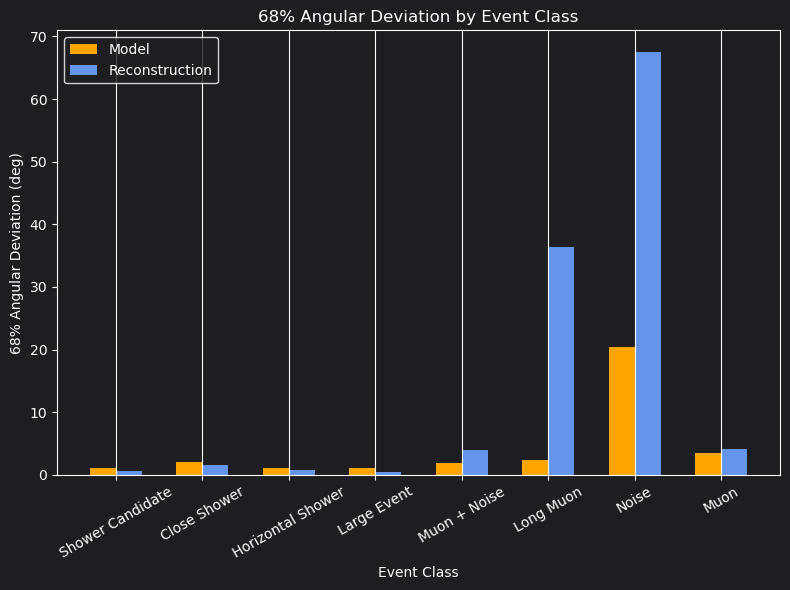

In [49]:
# Check the Event Class Distribution
# Dictionary to map Event Class index to label for x-ticks
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}

X  = []
Yp = []
Yr = []

for i, EventClass in enumerate(np.unique(Aux[:, 0])):
    X.append(EventClass)

    Mask = (Aux[:, 0] == EventClass)
    AngularDeviation_p = np.abs(np.arctan2(np.sin(Truth[Mask, 0] - Pred[Mask, 0]), np.cos(Truth[Mask, 0] - Pred[Mask, 0])))
    AngularDeviation_r = np.abs(np.arctan2(np.sin(Truth[Mask, 0] - Rec[Mask, 0]), np.cos(Truth[Mask, 0] - Rec[Mask, 0])))
    Yp.append(np.percentile(AngularDeviation_p * 180 / np.pi,68))
    Yr.append(np.percentile(AngularDeviation_r * 180 / np.pi,68))
    print(f'Event Class {event_class_labels.get(int(EventClass), str(int(EventClass)))}: {np.sum(Aux[:, 0] == EventClass)} events')
    # print(f'    Angular Deviation - Model: {Yp[-1]:.2f} deg, Reconstruction: {Yr[-1]:.2f} deg')

# Convert to numpy arrays
X  = np.array(X)
Yp = np.array(Yp)
Yr = np.array(Yr)

plt.figure(figsize=(8, 6))
plt.bar(X - 0.15, Yp, width=0.3, label='Model', color='orange')
plt.bar(X + 0.15, Yr, width=0.3, label='Reconstruction', color='cornflowerblue')
plt.xlabel('Event Class')
plt.ylabel('68% Angular Deviation (deg)')
plt.title('68% Angular Deviation by Event Class')
plt.xticks(X, [event_class_labels.get(int(x), str(int(x))) for x in X], rotation=30)
plt.legend()
plt.grid(axis='y')
# plt.yscale('log')
plt.show()

Primary Helium: 9432 events
Primary Proton: 9568 events
Primary Nitrogen: 8883 events
Primary Iron: 8464 events


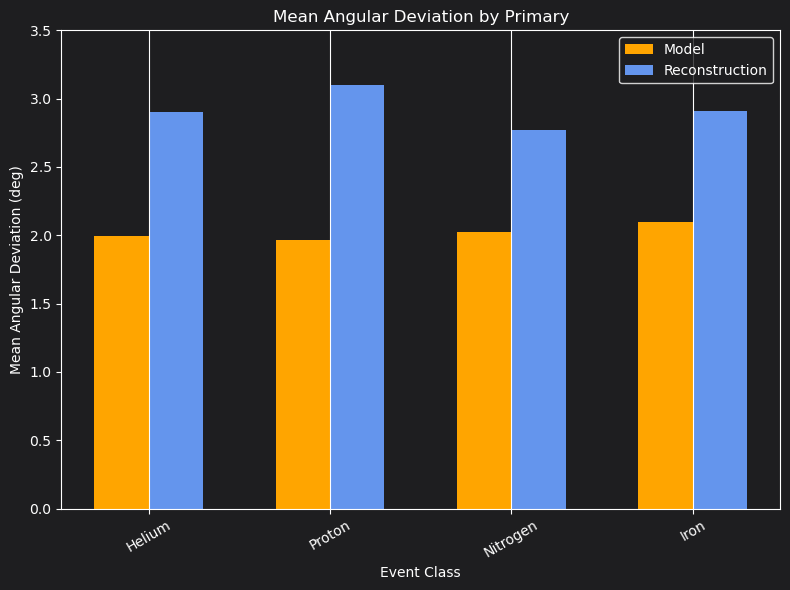

In [36]:
# Check the Primary Particles

# Dictionary to map Primary code to label for x-ticks
primary_labels = {
    26056: 'Iron',
    8016: 'Oxygen',
    2004: 'Helium',
    7014: 'Nitrogen',
    2212: 'Proton'
}

X  = []
Yp = []
Yr = []
for i, Primary in enumerate(np.unique(Aux[:, 1])):
    print(f'Primary {primary_labels.get(int(Primary), str(int(Primary)))}: {np.sum(Aux[:, 1] == Primary)} events')
    X.append(Primary)

    Mask = (Aux[:, 1] == Primary)
    AngularDeviation_p = np.abs(np.arctan2(np.sin(Truth[Mask, 0] - Pred[Mask, 0]), np.cos(Truth[Mask, 0] - Pred[Mask, 0])))
    AngularDeviation_r = np.abs(np.arctan2(np.sin(Truth[Mask, 0] - Rec[Mask, 0]), np.cos(Truth[Mask, 0] - Rec[Mask, 0])))
    Yp.append(np.percentile(AngularDeviation_p * 180 / np.pi,68))
    Yr.append(np.percentile(AngularDeviation_r * 180 / np.pi,68))
    
# Convert to numpy arrays
X  = np.array(X)
Yp = np.array(Yp)
Yr = np.array(Yr)

X = np.arange(len(X))  # Use indices for x-axis

plt.figure(figsize=(8, 6))
plt.bar(X - 0.15, Yp, width=0.3, label='Model', color='orange')
plt.bar(X + 0.15, Yr, width=0.3, label='Reconstruction', color='cornflowerblue')
plt.xlabel('Event Class')
plt.ylabel('Mean Angular Deviation (deg)')
plt.title('Mean Angular Deviation by Primary')
plt.xticks(X, [primary_labels.get(int(Primary), str(int(Primary))) for Primary in np.unique(Aux[:, 1])], rotation=30)
plt.legend()
plt.grid(axis='y')
plt.ylim(0,3.5)
plt.show()

Text(0.5, 0.98, 'Truth vs (Rec - Truth) for Gen_LogE')

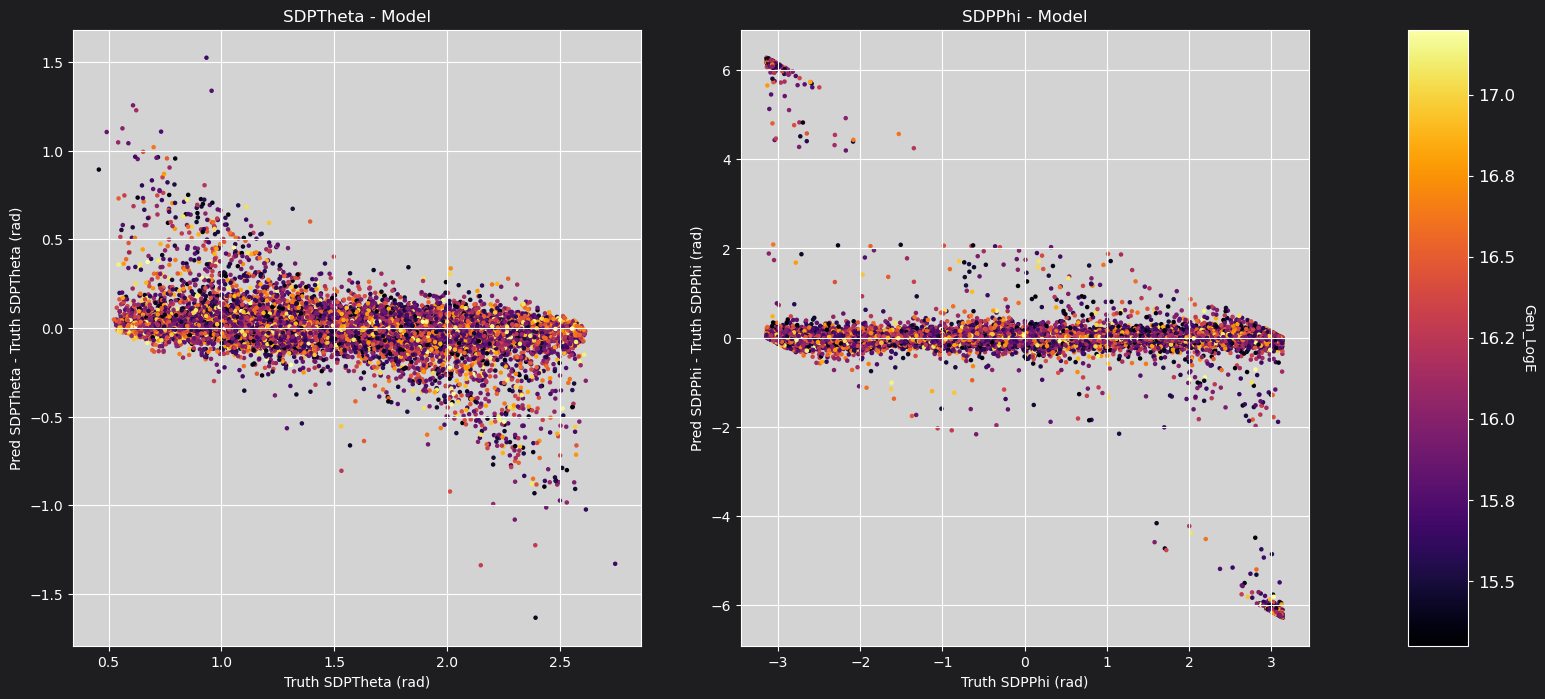

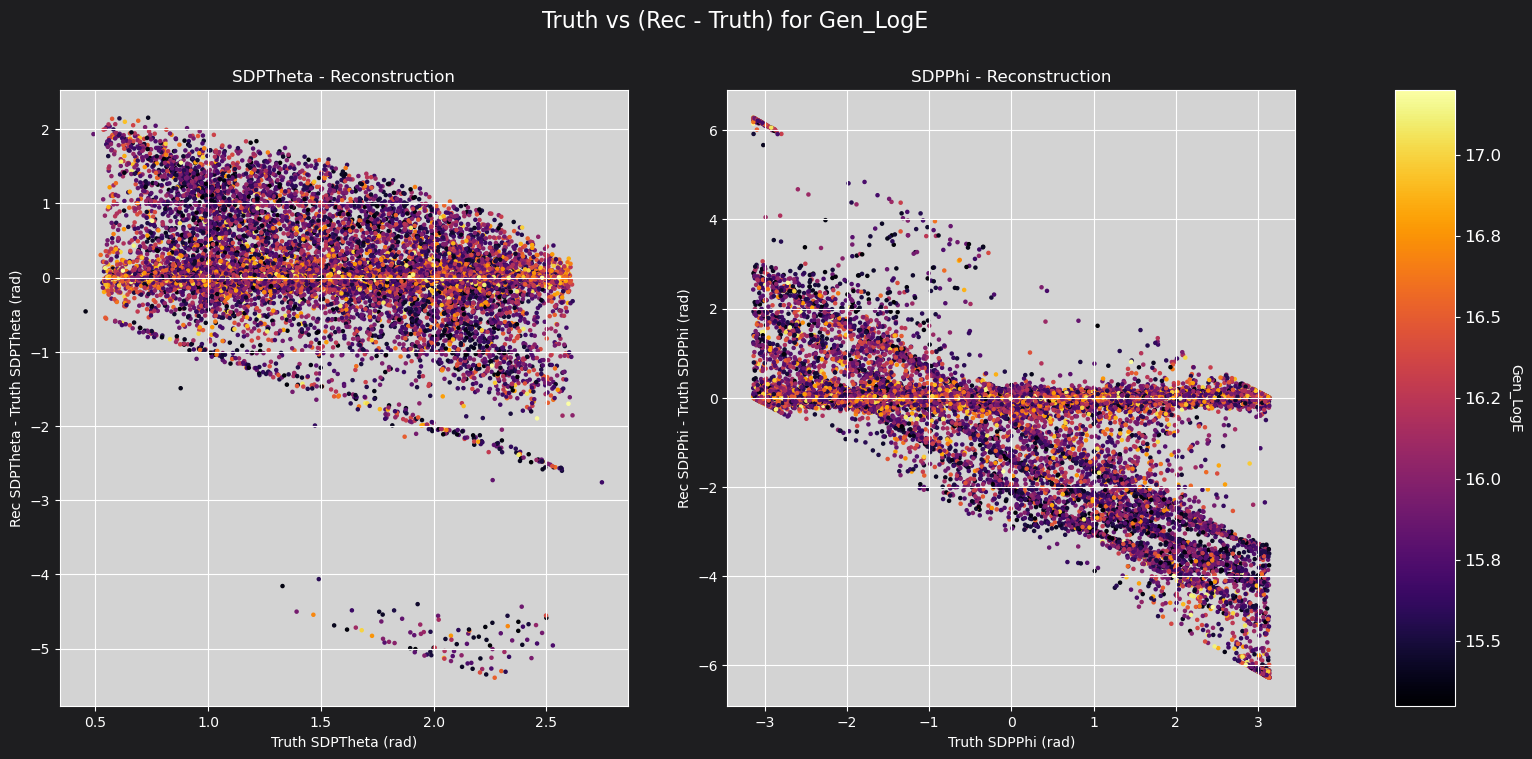

In [45]:
# Plot Truth vs (Pred - Truth) with color as SelectedVariable (Aux[:,2]), unified colorbar
import matplotlib.gridspec as gridspec

SelectVariable = 2
SelectedVariable = Aux[:, SelectVariable]  
SelectedVariableName = AuxKeys[SelectVariable]
vmin = np.min(SelectedVariable)
vmax = np.max(SelectedVariable)

fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.475, 0.475, 0.05], wspace=0.25)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
# subplot 3 is colorbar
cbar_ax = fig.add_subplot(gs[0, 2])

X_l = Truth[:, 0]
X_r = Truth[:, 1]

Y_l = Pred[:, 0] - Truth[:, 0]
Y_r = Pred[:, 1] - Truth[:, 1]

# Scatter plots
sc_l = axs[0].scatter(X_l, Y_l, c=SelectedVariable, s=5, cmap='inferno', vmin=vmin, vmax=vmax)
sc_r = axs[1].scatter(X_r, Y_r, c=SelectedVariable, s=5, cmap='inferno', vmin=vmin, vmax=vmax)
# Set labels and titles
axs[0].set_xlabel('Truth SDPTheta (rad)')
axs[0].set_ylabel('Pred SDPTheta - Truth SDPTheta (rad)')
axs[0].set_title('SDPTheta - Model')
axs[1].set_xlabel('Truth SDPPhi (rad)')
axs[1].set_ylabel('Pred SDPPhi - Truth SDPPhi (rad)')
axs[1].set_title('SDPPhi - Model')

# Add colorbar
cbar = fig.colorbar(sc_l, cax=cbar_ax)
cbar.set_label(f'{SelectedVariableName}', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in cbar.get_ticks()])  # Format colorbar ticks

cbar_ax.grid()

axs[0].set_facecolor('lightgrey')
axs[1].set_facecolor('lightgrey')


# Make the same plot for Rec
# Plot Truth vs (Rec - Truth) with color as SelectedVariable (Aux[:,2]), unified colorbar

fig2 = plt.figure(figsize=(18, 8))
gs2 = gridspec.GridSpec(1, 3, width_ratios=[0.475, 0.475, 0.05], wspace=0.25)
axs2 = [fig2.add_subplot(gs2[0, 0]), fig2.add_subplot(gs2[0, 1])]
cbar_ax2 = fig2.add_subplot(gs2[0, 2])

Y_l_rec = Rec[:, 0] - Truth[:, 0]
Y_r_rec = Rec[:, 1] - Truth[:, 1]

sc_l2 = axs2[0].scatter(X_l, Y_l_rec, c=SelectedVariable, s=5, cmap='inferno', vmin=vmin, vmax=vmax)
sc_r2 = axs2[1].scatter(X_r, Y_r_rec, c=SelectedVariable, s=5, cmap='inferno', vmin=vmin, vmax=vmax)

axs2[0].set_xlabel('Truth SDPTheta (rad)')
axs2[0].set_ylabel('Rec SDPTheta - Truth SDPTheta (rad)')
axs2[0].set_title('SDPTheta - Reconstruction')
axs2[1].set_xlabel('Truth SDPPhi (rad)')
axs2[1].set_ylabel('Rec SDPPhi - Truth SDPPhi (rad)')
axs2[1].set_title('SDPPhi - Reconstruction')

cbar2 = fig2.colorbar(sc_l2, cax=cbar_ax2)
cbar2.set_label(f'{SelectedVariableName}', rotation=270, labelpad=15)
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.set_yticklabels([f'{tick:.1f}' for tick in cbar2.get_ticks()])

cbar_ax2.grid()

axs2[0].set_facecolor('lightgrey')
axs2[1].set_facecolor('lightgrey')


fig2.suptitle(f'Truth vs (Rec - Truth) for {SelectedVariableName}', fontsize=16)